# Estimate signal parameters

...by computing the likelihood on a grid.

Notation:
* Capital letters refer to Fourier components, e.g.: `h` = $h(t)$ and `H` = $\tilde h(f)$.
* $s(t) = h(t) + n(t)$, (strain = template + noise)

In [1]:
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerLine2D
import matplotlib.lines as mlines
import matplotlib.gridspec as gridspec
from matplotlib.legend_handler import HandlerPatch
import scipy.ndimage as ndimage
from scipy.interpolate import UnivariateSpline, griddata
from scipy.optimize import brentq
from multiprocessing import Pool, cpu_count

In [2]:
events = ['GW170608',
          'GW151226',
          'LVT151012',
          'GW170104',
          'GW170814',
          'GW150914',
         ]  # Increasing Mchirp

approximants = [#'IMRPhenomD',
                'SEOBNRv4_ROM'
               ]
coherences = ['coherent', 
              'incoherent',
             ]
PSDs = ['ASD_average']

In [3]:
coherences_approximants = [[coherence, approximant]
                           for coherence in coherences 
                           for approximant in approximants]
PSDs_approximants = [[psd, approximant]
                     for psd in PSDs
                     for approximant in approximants]

## Load
* template parameters and SNR
* parameter values reported by LIGO
* sensitive volume $V(\mathbf{p})$ on a full $\mathbf{p}$-grid to interpolate over each event's grid (might want to report it by `compute_likelihood.py` at some point)

In [4]:
parameters, ligo_parameters, original_num, original_nums, grid_params = {}, {}, {}, {}, {}
for event in events:
    parameters[event] = pd.read_csv(event + '/parameter_grid', sep='\s+')

    ligo_parameters[event] = pd.read_csv('{0}/{0}_LIGO_parameters'.format(event), sep='\s+', comment='#')

    with open(event + '/grid_metadata') as  grid_metadata:
        grid_params[event] = grid_metadata.readline().strip().split()
        original_num[event] = dict(zip(grid_params[event], 
                                       [int(x) for x in grid_metadata.readline().strip().split()]))
    original_nums[event] = np.array(list(original_num[event].values()))
assert all(grid_params[e] == grid_params[events[0]] for e in events)
grid_params = grid_params[events[0]]  # Have a single list valid for all events

In [5]:
# Load SNR_1Mpc on full p-grid
full_p_grid = pd.read_csv('../2-estimate_horizon/all_par_space/parameter_grid', sep='\s+')
full_p_grid_metadata = pd.read_csv('../2-estimate_horizon/all_par_space/grid_metadata', sep='\s+')
p_grid_1d = {par: np.sort(list(set(full_p_grid[par].values))) for par in grid_params}  # Of the full p-grid

assert all(full_p_grid_metadata.columns == grid_params)

## Interpolate 
...the likelihood on a grid on the space of physical parameters $(\mathcal{M}, q, \chi_{\rm eff}, \ldots)$.

In [6]:
# Define the 1d grids, interpolation grid and 2d grids
zoom = 2  # Refine grid by this factor with interpolation (make it integer)
num, grid_2d_params = {}, {}
grid, grid_1d, original_grid_1d = {e:{} for e in events}, {e:{} for e in events}, {e:{} for e in events}
grid_2d = {e:{} for e in events}
grid_2d_params = [(x_par, y_par) for i, x_par in enumerate(grid_params) for y_par in grid_params[i+1:]]
for event in events:
    num[event] = dict(zip(grid_params, original_nums[event] * zoom)) # New grid size
    for par in grid_params:
        min_max = [m(parameters[event][par]) for m in [min, max]]
        grid_1d[event][par] = np.linspace(*min_max, num[event][par])
        original_grid_1d[event][par] = np.linspace(*min_max, original_num[event][par])
    grid[event] = dict(zip(grid_params, np.meshgrid(*[grid_1d[event][par] for par in grid_params],
                                                    indexing='ij')))
    for xy_pars in grid_2d_params:
        grid_2d[event][xy_pars] = dict(zip(xy_pars, np.meshgrid(*[grid_1d[event][par] for par in xy_pars],
                                                                indexing='ij')))

In [7]:
original_grid = {e:{} for e in events}
for event in events:
    for key in parameters[event]:
        original_grid[event][key] = np.reshape(parameters[event][key].values, (original_nums[event]))
    # Consistency check:
    assert(np.allclose([original_grid[event][par] for par in grid_params], 
                       np.meshgrid(*[original_grid_1d[event][par] for par in grid_params], indexing='ij'),
                       atol=1e-2)), 'There was some problem reconstructing the parameter_grid'

In [8]:
# Interpolate likelihood:
for event in events:
    for CA in coherences_approximants:
        grid[event]['likelihood', (*CA)] = ndimage.zoom(np.exp(original_grid[event]['logL_{}_{}'.format(*CA)]),
                                                        zoom, order=1)

In [9]:
# Interpolate sensitive volume over each event's grid
min_val, max_val = ({par: f(full_p_grid[par]) for par in grid_params} for f in (min, max))
for PA in PSDs_approximants:
    V = full_p_grid['SNR_1Mpc_' + '_'.join(PA)].values.reshape(full_p_grid_metadata.values[0])**3
    for event in events:
        grid[event]['V', (*PA)] = ndimage.map_coordinates(
            V, [(grid[event][par] - min_val[par]) * (
                (full_p_grid_metadata[par][0]-1) / (max_val[par]-min_val[par])) for par in grid_params])


#### Interpolation for $q, \chi_{\rm eff}$
... is degenerate for low-mass BBHs and benefits from a change of variables to $\eta, \chi_{\rm PN}$ before the interpolation.

This interpolation is on an irregular grid and thus much slower, uses `griddata`. 

## Marginalized posteriors

$P = P_{\rm prior}\mathcal{L}$. To connect priors in $(m_1, m_2)$ to $(\mathcal{M}, q)$ use:

$$P_{\rm prior}(\mathcal{M}, q) = P_{\rm prior}(m_1, m_2) \frac{\left(1 + \frac{1}{q}\right)^{1/5}  (1 + q)^{1/5}}{q} \mathcal{M}$$

The LIGO spin prior is uniform in the individual spin magnitudes $a_{1,2}$ and tilt cosines $\cos\theta_{1,2}$. This yields the following prior for $\chi_{\rm eff}$:
$$
\begin{aligned}
    P_{\rm prior}(\chi_{\rm eff} \mid q)
         &= (1+q) \int_a^b P_\chi \left( (1+q) \chi_{\rm eff} - q \chi_2 \right) 
             P_\chi(\chi_2) {\rm d}\chi_2, \\
    P_\chi(\chi) &\propto \log \frac{1}{\left| \chi \right|}  \\
    a &= \max \left(\frac{(1+q)\chi_{\rm eff} - 1}{q}, -1 \right) \\
    b &= \min \left(\frac{(1+q)\chi_{\rm eff} + 1}{q}, 1 \right).
\end{aligned}
$$
In the implementation below we use that it doesn't depend on $\mathcal M$.

In [10]:
def Heaviside(x):
    return x >= 0

In [11]:
# Define the priors:
#def P_LIGO_chi(chi):  # P_LIGO(X1) = P_LIGO(X2), individual aligned spins
#    return np.log((1 + np.sqrt(1-chi**2)) / np.maximum(np.abs(chi), 1e-3))
def P_LIGO_chi(chi):  # P_LIGO(X1) = P_LIGO(X2), individual aligned spins
    return - np.log(np.maximum(np.abs(chi), 1e-3))
def P_LIGO_chieff_given_q(q, chi_eff):  # P_LIGO(Xeff | q), must be floats
    chi2, dchi2 = np.linspace(max((chi_eff - 1) / q + chi_eff, -1), 
                              min((chi_eff + 1) / q + chi_eff,  1),
                              800, endpoint=False, retstep=True)
    chi2 += dchi2/2
    return (1+q) * (P_LIGO_chi((1+q)*chi_eff-q*chi2) * P_LIGO_chi(chi2)).sum()*dchi2
def LIGO_prior(event, M_chirp, q, **kwargs):
    assert grid_params == ['M_chirp', 'q', 'chi_eff']  # ... or you'll have to change this implementation
    p = Pool(cpu_count())
    q_chi_eff = [[q, chi_eff] for q, chi_eff in zip(grid_2d[event]['q', 'chi_eff']['q'].flatten(),
                                                    grid_2d[event]['q', 'chi_eff']['chi_eff'].flatten())]
    P_chieff_given_q = np.reshape(p.starmap(P_LIGO_chieff_given_q, q_chi_eff),
                                  grid_2d[event]['q', 'chi_eff']['chi_eff'].shape) 
    return M_chirp * (1+1/q)**.2 * (1+q)**.2 / q * P_chieff_given_q[np.newaxis,:,:]
LIGO_prior.latex = 'LIGO'
LIGO_prior.text = 'LIGO'

def uniform_in_m1_m2_chieff(M_chirp, q, **kwargs):
    return M_chirp * (1+1/q)**.2 * (1+q)**.2 / q
uniform_in_m1_m2_chieff.latex = r'Uniform in $m_1, m_2, \chi_{{\rm eff}}$'
uniform_in_m1_m2_chieff.text = 'Uniform in m1, m2, Xeff'

def uniform_in_m1_m2_chi1_chi2(M_chirp, q, chi_eff, **kwargs):
    return M_chirp * (1+1/q)**.2 * (1+q)**.2 / q * (
        -((1+q)*(Heaviside(-((1+q)*(-1+chi_eff)))*((1+q)*(-1+chi_eff)-(1+q*(-1+chi_eff)+chi_eff)
        *Heaviside(-1+q-(1+q)*chi_eff))+(1-q-(1+q)*chi_eff+(1+q)*(1+chi_eff)
        *Heaviside(-((1+q)*(1+chi_eff))))*Heaviside(1-chi_eff-q*(1+chi_eff))))/(4.*q))
uniform_in_m1_m2_chi1_chi2.latex = r'Uniform in $m_1, m_2, \chi_1, \chi_2$'
uniform_in_m1_m2_chi1_chi2.text = 'Uniform in m1, m2, X1, X2'

def uniform_in_Mchirp_q_chieff(M_chirp, **kwargs):
    return np.ones_like(M_chirp)
uniform_in_Mchirp_q_chieff.latex = r'Uniform in $\mathcal{{M}}, q, \chi_{{\rm eff}}$'
uniform_in_Mchirp_q_chieff.text = 'Uniform in Mchirp, q, Xeff'

def V_times_LIGO_prior(event, M_chirp, q, V, **kwargs):
    return V * LIGO_prior(event, M_chirp, q)
V_times_LIGO_prior.latex = r'$V \times$ LIGO'
V_times_LIGO_prior.text = 'VxLIGO'

def V_times_uniform_in_Mchirp_q_chieff(V, **kwargs):
    return V
V_times_uniform_in_Mchirp_q_chieff.latex = r'$V(\mathcal{{M}}, q, \chi_{{\rm eff}})$'
V_times_uniform_in_Mchirp_q_chieff.text = 'V(Mchirp, q, Xeff)'

priors = [LIGO_prior,
          #V_times_LIGO_prior,
          uniform_in_Mchirp_q_chieff,
          #V_times_uniform_in_Mchirp_q_chieff,
          #uniform_in_m1_m2_chieff,
          #uniform_in_m1_m2_chi1_chi2,
         ]
for prior in priors:
    prior.name = prior.__name__  # Easier

In [12]:
priors_coherences_approximants = [[prior.name, coherence, approximant]
                                  for prior in priors 
                                  for coherence in coherences 
                                  for approximant in approximants]

In [13]:
for event in events:
    for prior in priors:
        # TODO: Put a for loop for PA if we have >1
        P = prior(event=event, **{par:grid[event][par] for par in grid_params},
                  V=grid[event]['V', (*PA)])
        grid[event][prior.name] = P / P.sum()
        for CA in coherences_approximants:
            P = grid[event][prior.name] * grid[event]['likelihood', ((*CA))]
            grid[event]['posterior', prior.name, (*CA)] = P / P.sum()

        # Compute 1d marginalized priors and posteriors:
        for i, x_par in enumerate(grid_params):
            js = tuple(j for j in range(len(grid_params)) if j != i) # Marginalize over these axes
            grid_1d[event][prior.name, x_par] = grid[event][prior.name].sum(axis=js)
            for CA in coherences_approximants:
                grid_1d[event]['posterior', prior.name, (*CA), x_par] \
                    = grid[event]['posterior', prior.name, (*CA)].sum(axis=js)

        # Compute 2d marginalized posteriors
        for xy_pars in grid_2d_params:
            for CA in coherences_approximants:
                js = tuple(j for j, z in enumerate(grid_params) if not z in xy_pars) # Marginalize over these axes
                grid_2d[event][xy_pars]['posterior', prior.name, (*CA)] \
                    = grid[event]['posterior', prior.name, (*CA)].sum(axis=js)

### Find parameter estimates

In [14]:
median, bounds_estimate, err_estimate = {e:{} for e in events}, {e:{} for e in events}, {e:{} for e in events}
for event in events:
    for PCA in priors_coherences_approximants:
        for par in grid_params:
            cumulative_P = UnivariateSpline(grid_1d[event][par], 
                                            np.cumsum(grid_1d[event]['posterior', (*PCA), par]) - .5,
                                            s=0)
            median[event][(*PCA), par] = cumulative_P.roots()[0]

            P_level = brentq(lambda level, P: P[P > level].sum()-.9, 0, 1, 
                             args=(grid_1d[event]['posterior', (*PCA), par]))
            P_spline = UnivariateSpline(grid_1d[event][par],
                                        grid_1d[event]['posterior', (*PCA), par] - P_level,
                                        s=0)
            roots = P_spline.roots()
            bounds_estimate[event][(*PCA), par] = np.array([roots[0], roots[-1]])
            if grid_1d[event]['posterior', (*PCA), par][0] > P_level:
                bounds_estimate[event][(*PCA), par][0] = grid_1d[event][par][0]
            if grid_1d[event]['posterior', (*PCA), par][-1] > P_level:
                bounds_estimate[event][(*PCA), par][1] = grid_1d[event][par][-1]
            err_estimate[event][(*PCA), par] = abs(median[event][(*PCA), par] - bounds_estimate[event][(*PCA), par])

### Find % confidence contours

In [15]:
fractions = [.5, .9]  # Probability enclosed by contours
fractions = sorted(fractions, reverse=True)  # So that the P levels are increasing
levels = {e:{} for e in events}
for event in events:
    for PCA in priors_coherences_approximants:
        for xy_pars in grid_2d_params:
            levels[event][(*PCA), xy_pars] = [brentq(lambda level, P: P[P > level].sum()-fraction, 0, 1,
                                                   args=(grid_2d[event][xy_pars]['posterior', (*PCA)]))
                                            for fraction in fractions]

### Probability that $\chi_{\rm eff}>0$

## Plot

In [16]:
latex = {'M_chirp': r'$\mathcal{{M}}$',
         'q': r'$q$',
         'chi_eff': r'$\chi_{{\rm eff}}$'}
unit = {'M_chirp': r' (${\rm M}_\odot$)',
        'q': '', 'chi_eff': ''}

In [17]:
def latex_val_err(v, e):  # e == [err_m, err_p]
    n_digits = max(0, *[int(np.ceil(-np.log10(e_))) for e_ in e])
    r = lambda a, n: round(a, n) if n > 0 else int(round(a))
    return '${}_{{-{}}}^{{+{}}}$'.format(r(v, n_digits), *[r(e_, n_digits) for e_ in e])

### Maximally spinning secondary
The case where the secondary BH is maximally spinning (e.g. due to tidal locking of the progenitor star) and the primary is not spinning defines a curve in the $\chi_{\rm eff},q$ plane:
$$\chi_{\rm eff, locked} = \frac{q}{1+q} ~\Longleftrightarrow~ q_{\rm locked} = \frac{\chi_{\rm eff}}{1-\chi_{\rm eff}}$$

In [18]:
def chi_eff_locked(q):
    return q / (1 + q)
def q_locked(chi_eff):
    return chi_eff / (1 - chi_eff +1e-10)  # Prevent /0

locked = {e:{} for e in events}
for event in events:
    chi_eff_min, chi_eff_max = grid_1d[event]['chi_eff'][[0, -1]]
    q_min, q_max = grid_1d[event]['q'][[0, -1]]
    if chi_eff_max > chi_eff_locked(q_min) and chi_eff_min < chi_eff_locked(q_max):
        q1 = max(q_min, q_locked(chi_eff_min))
        q2 = min(q_max, q_locked(chi_eff_max))
        locked[event]['q'] = np.linspace(q1, q2)
        locked[event]['chi_eff'] = chi_eff_locked(locked[event]['q'])

### Single-event corner plots
#### Single prior

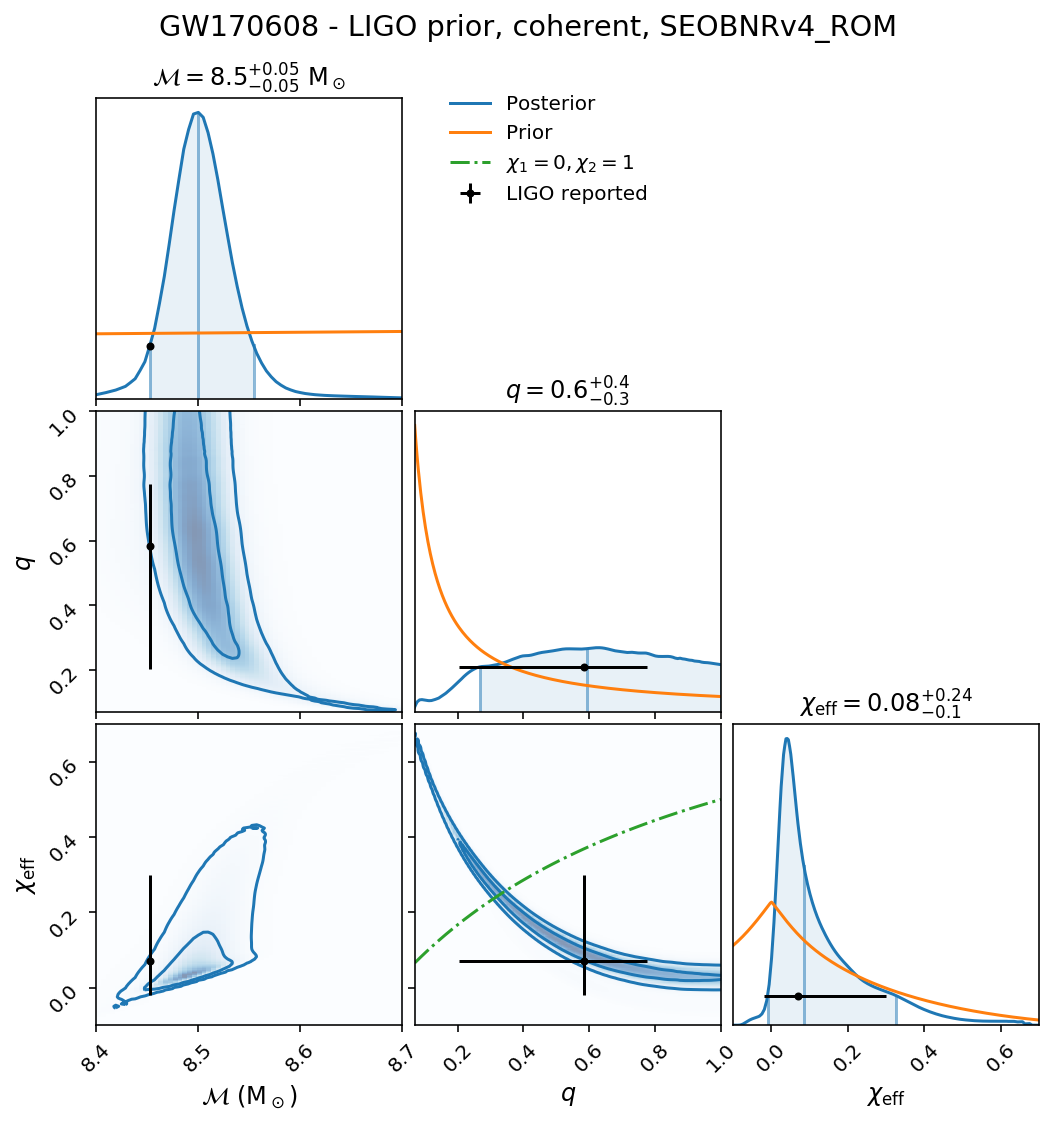

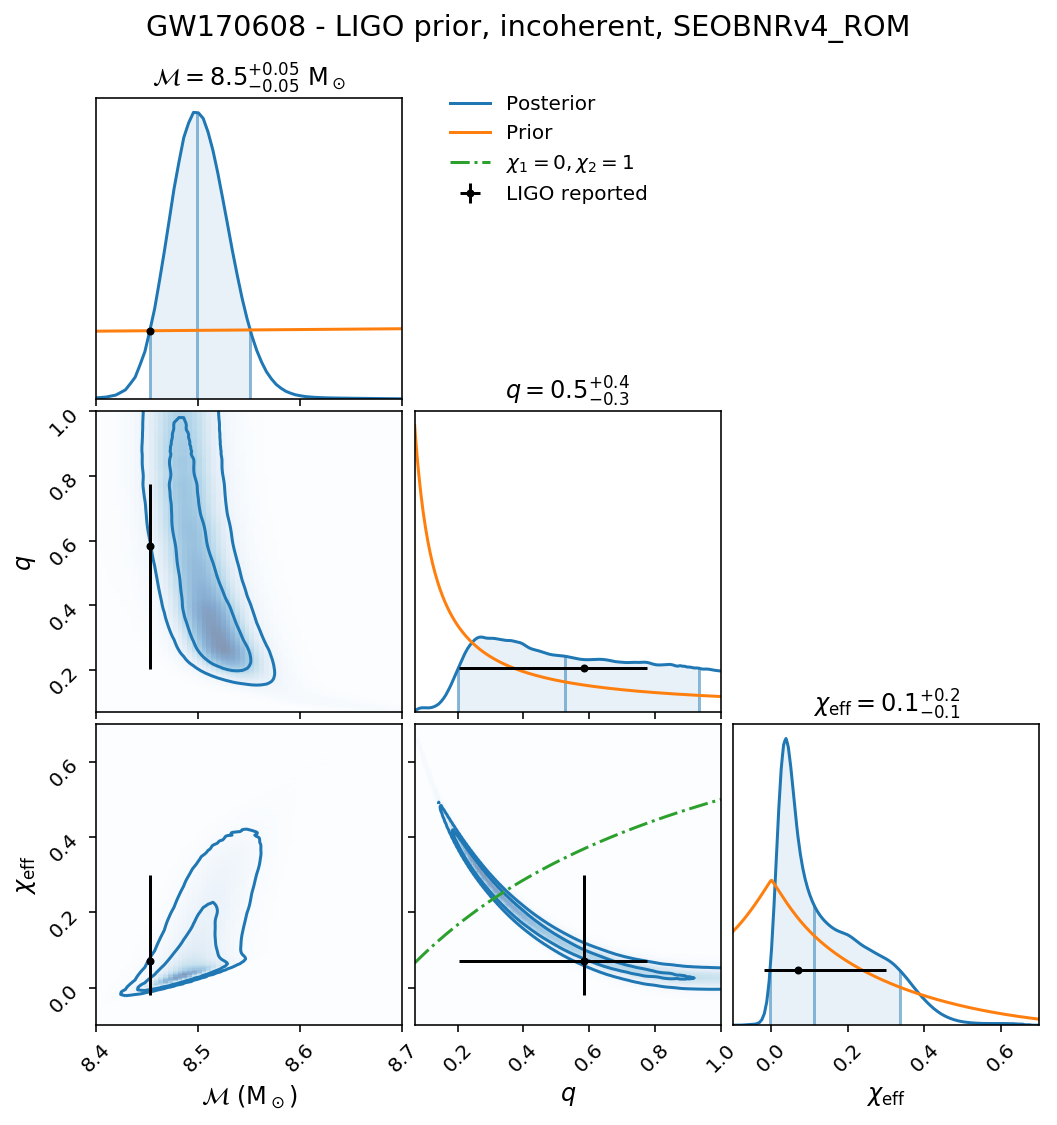

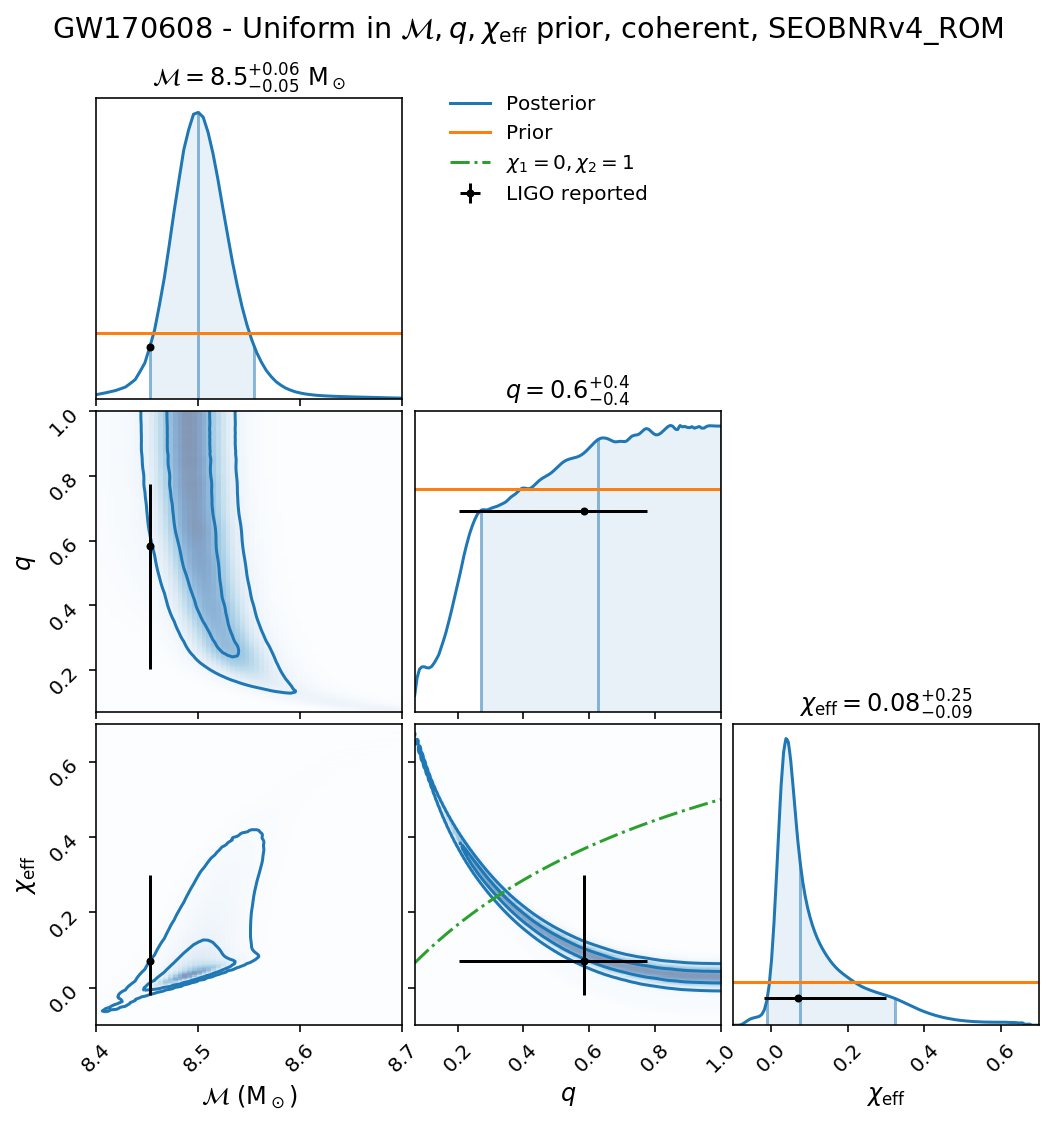

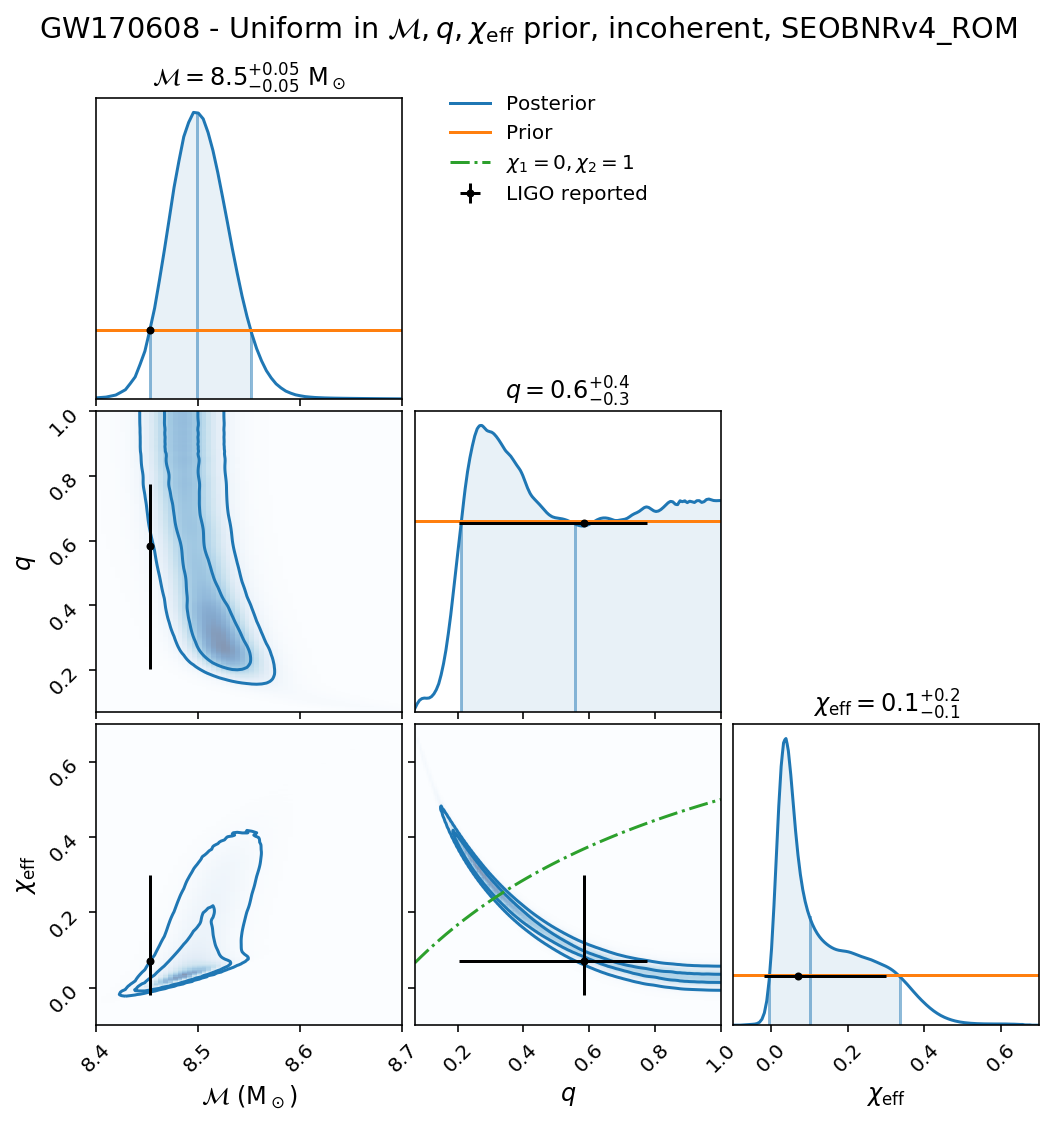

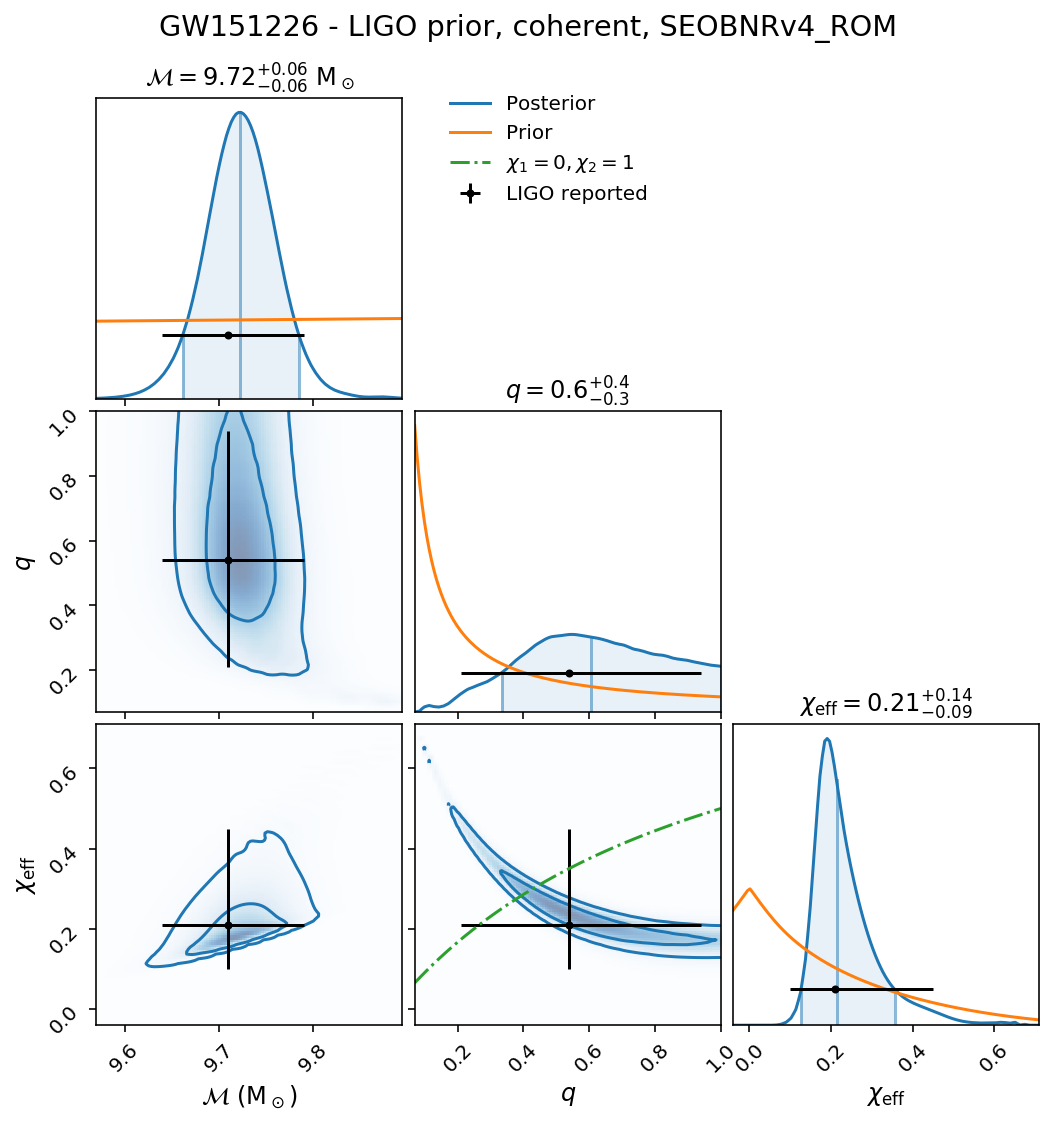

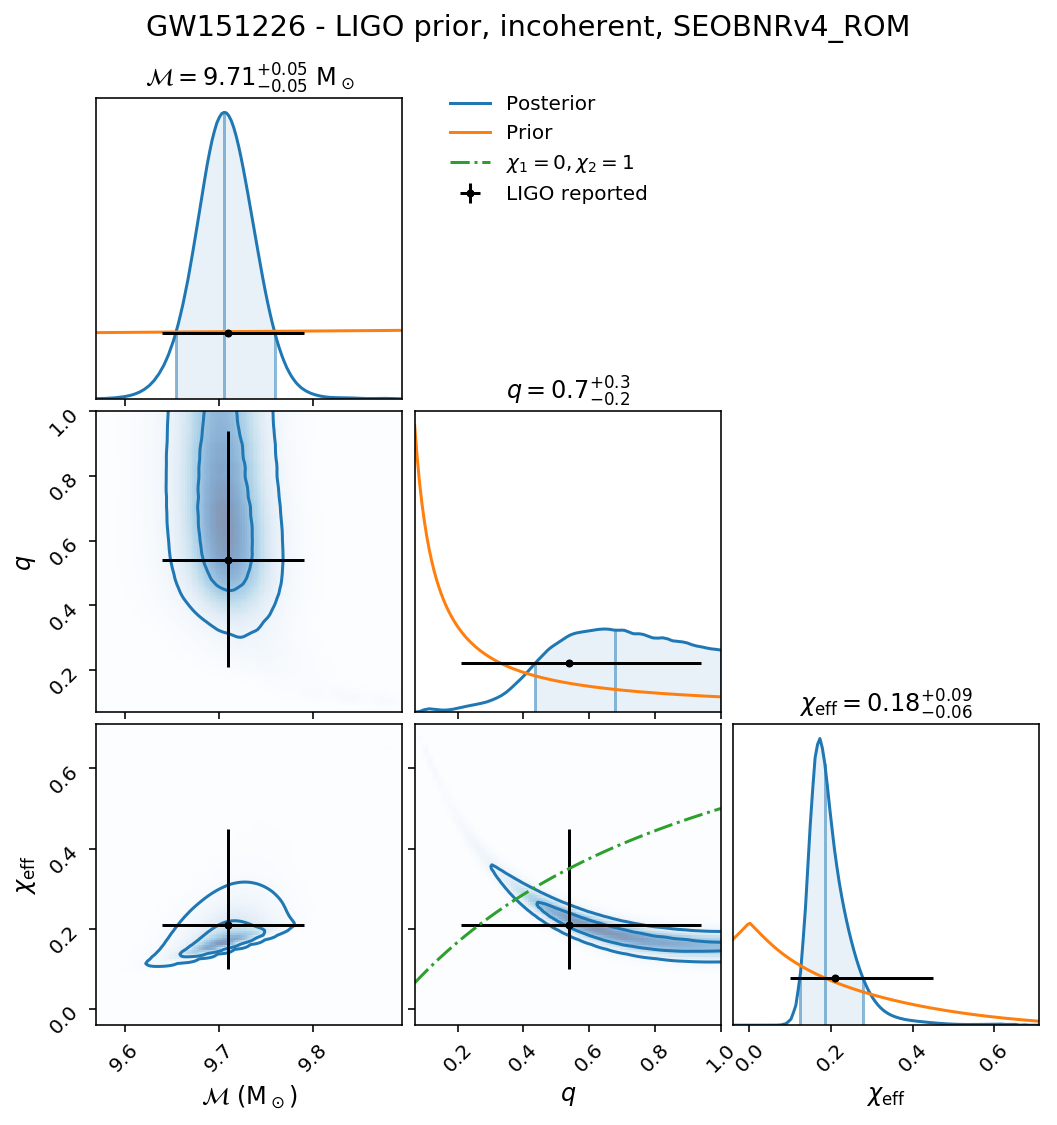

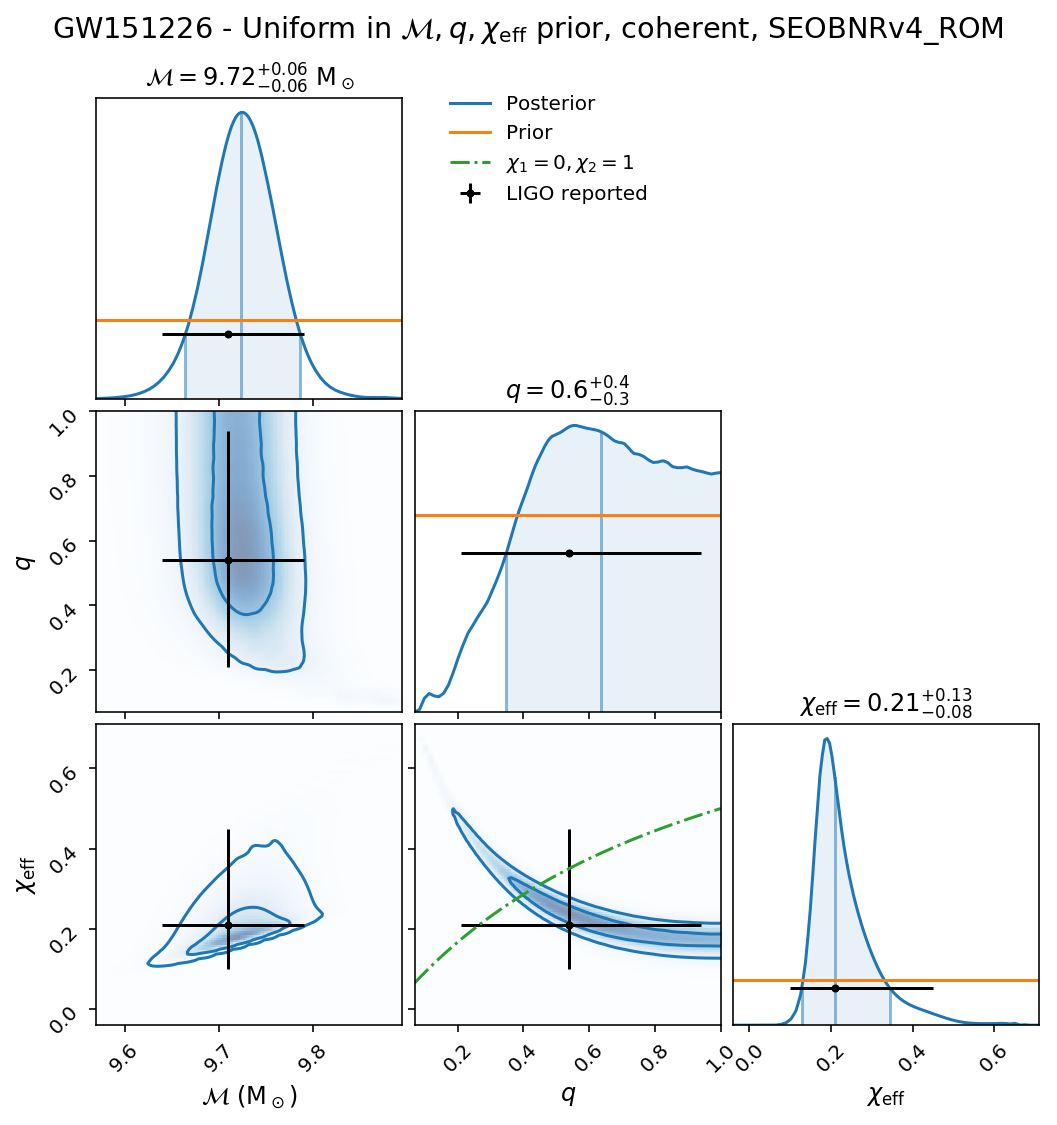

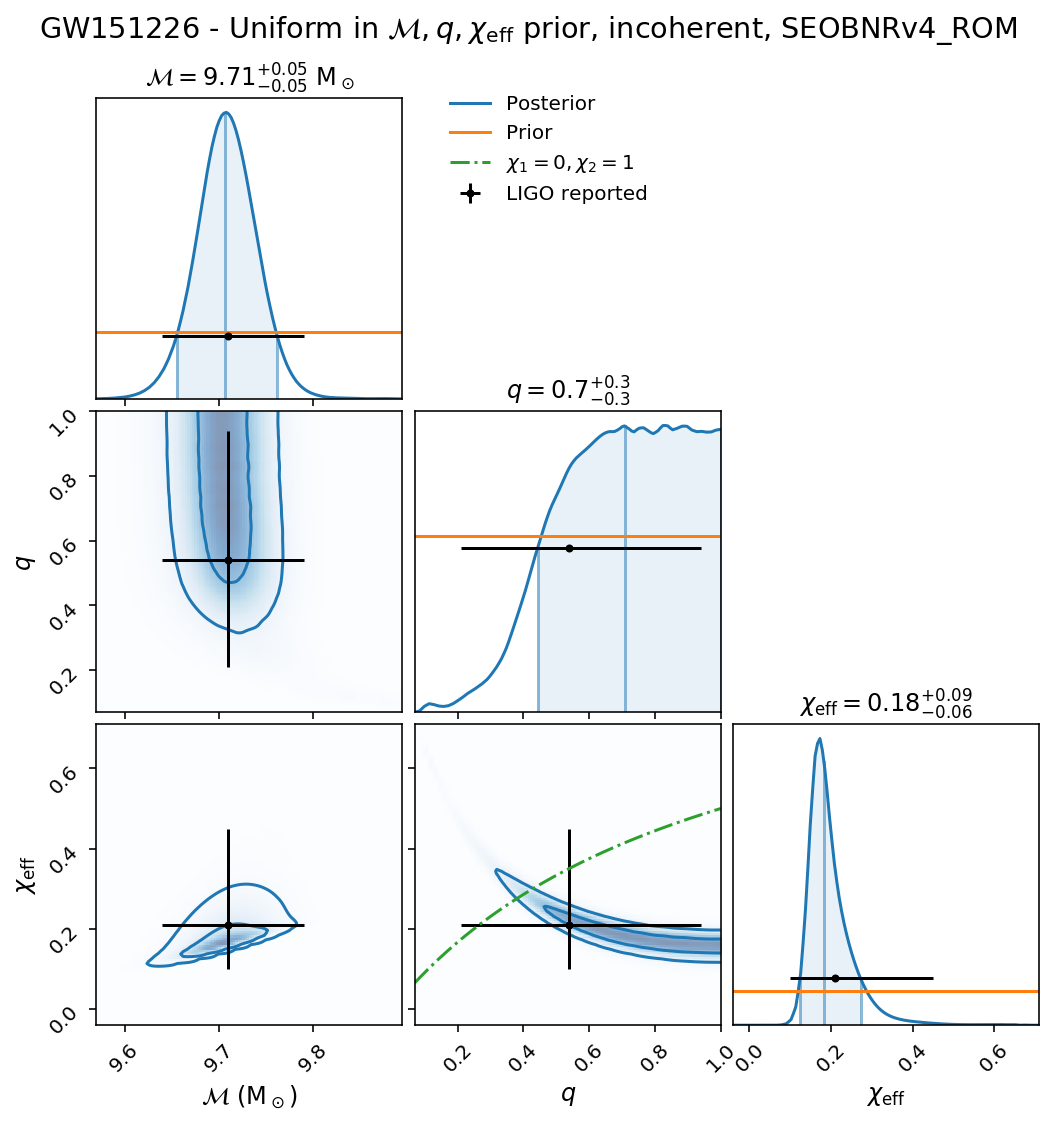

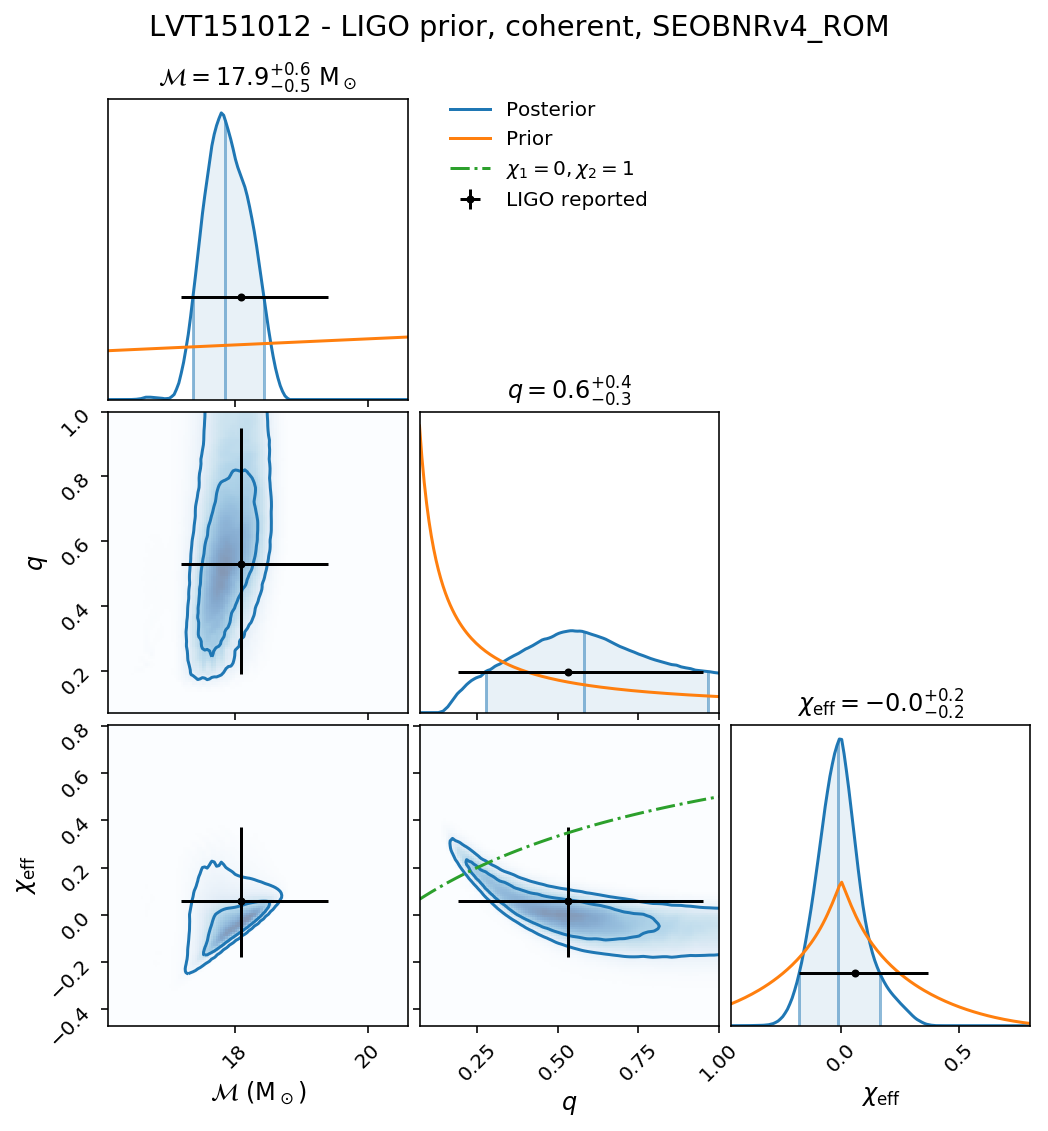

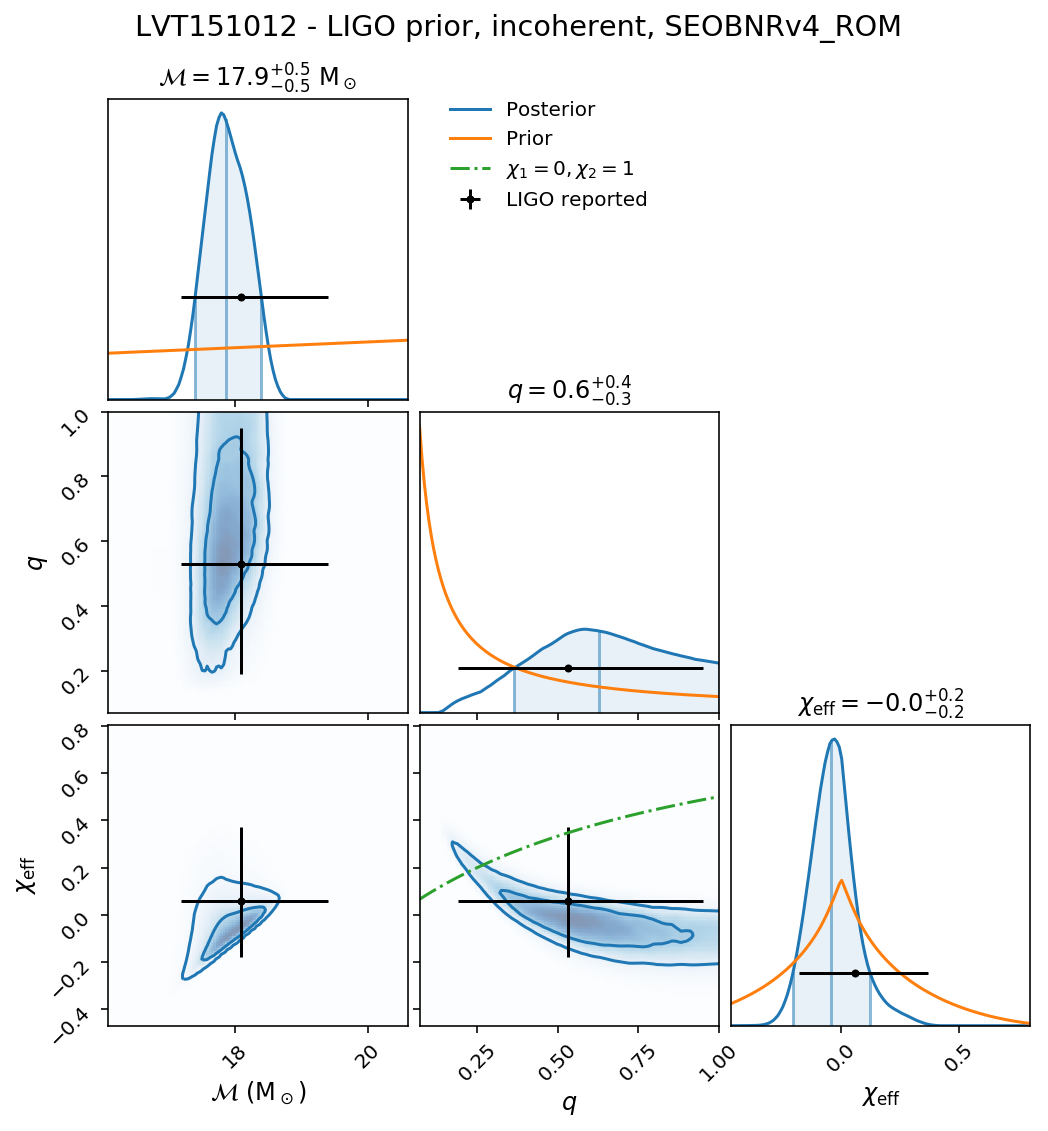

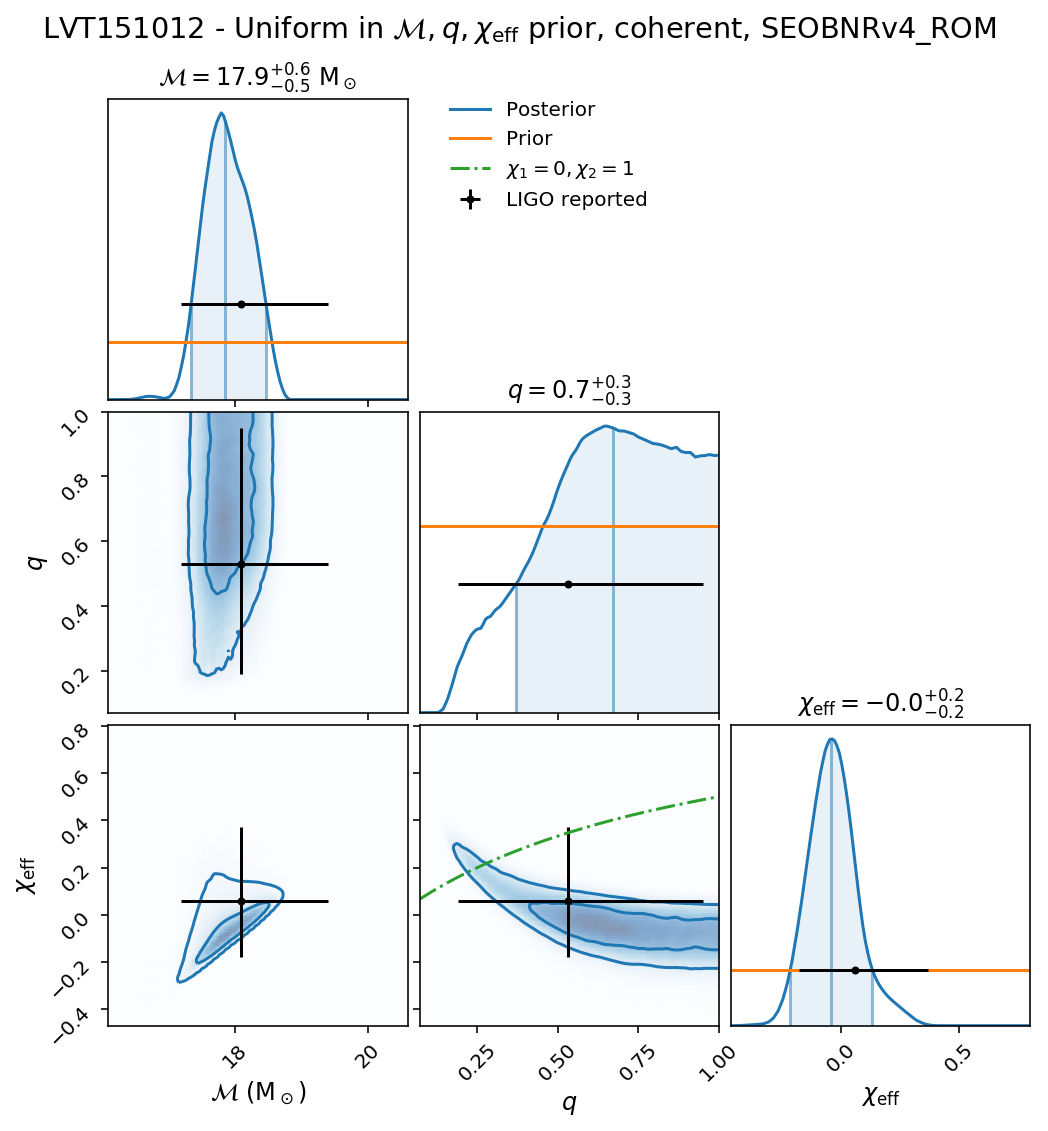

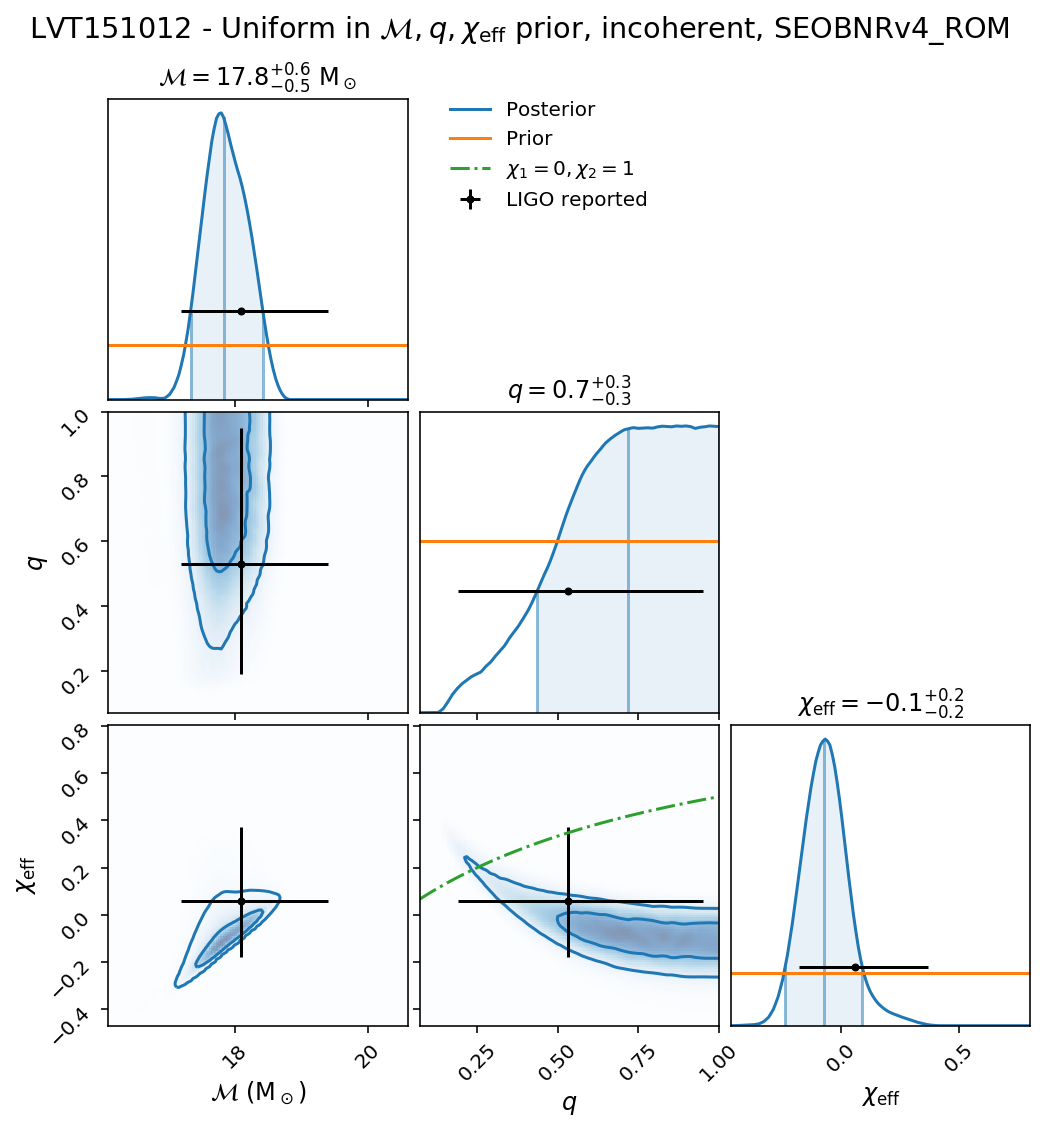

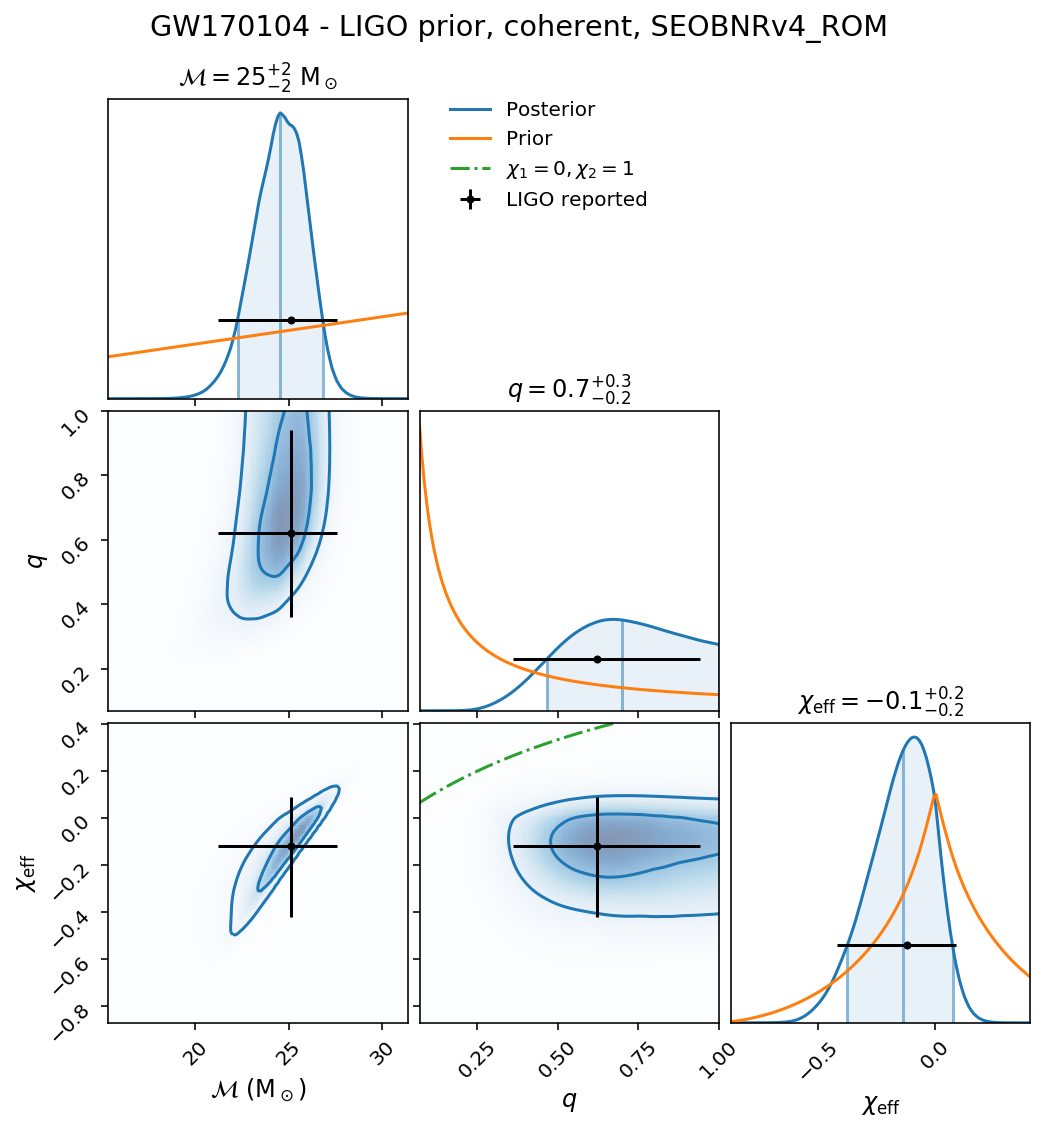

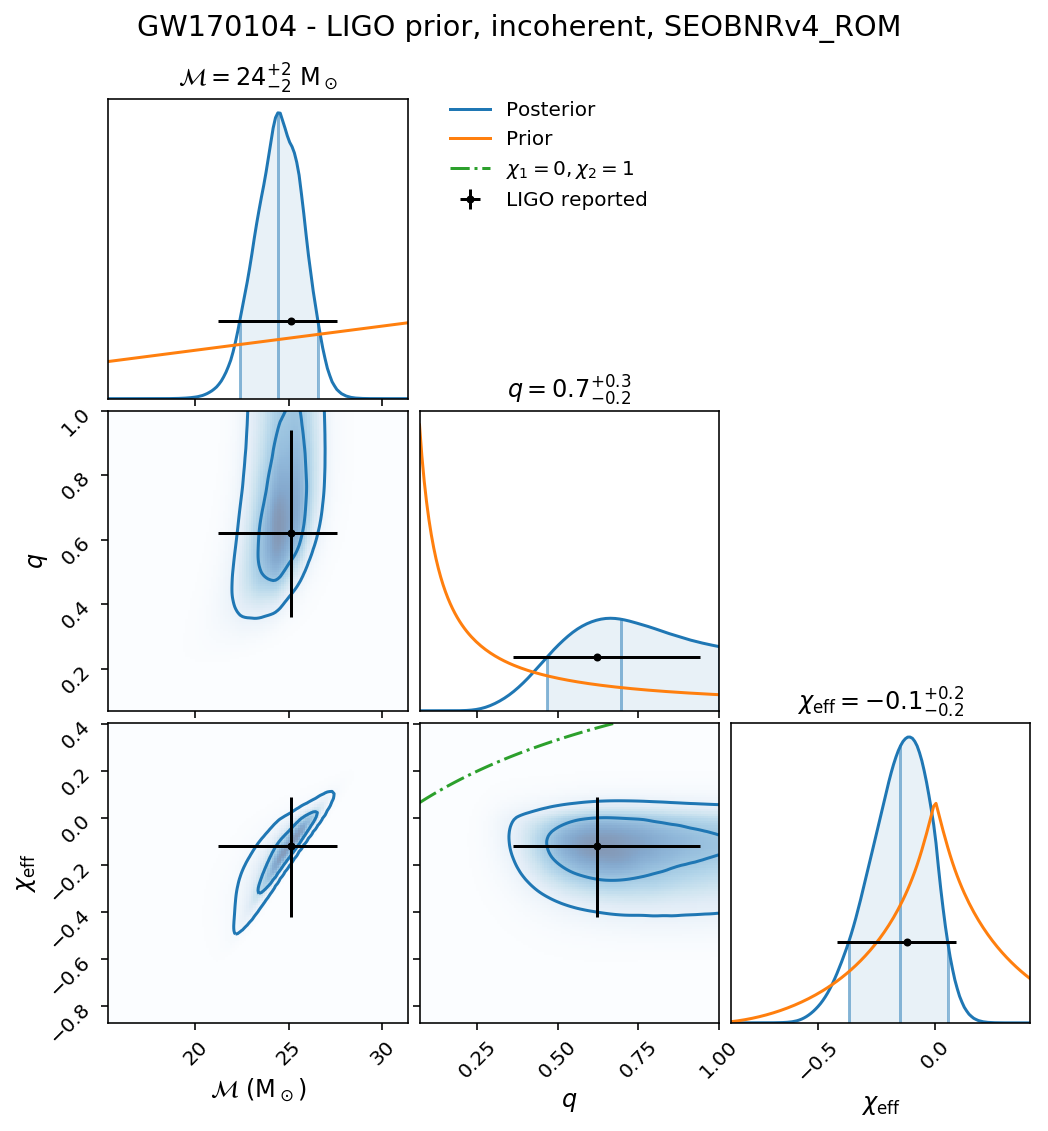

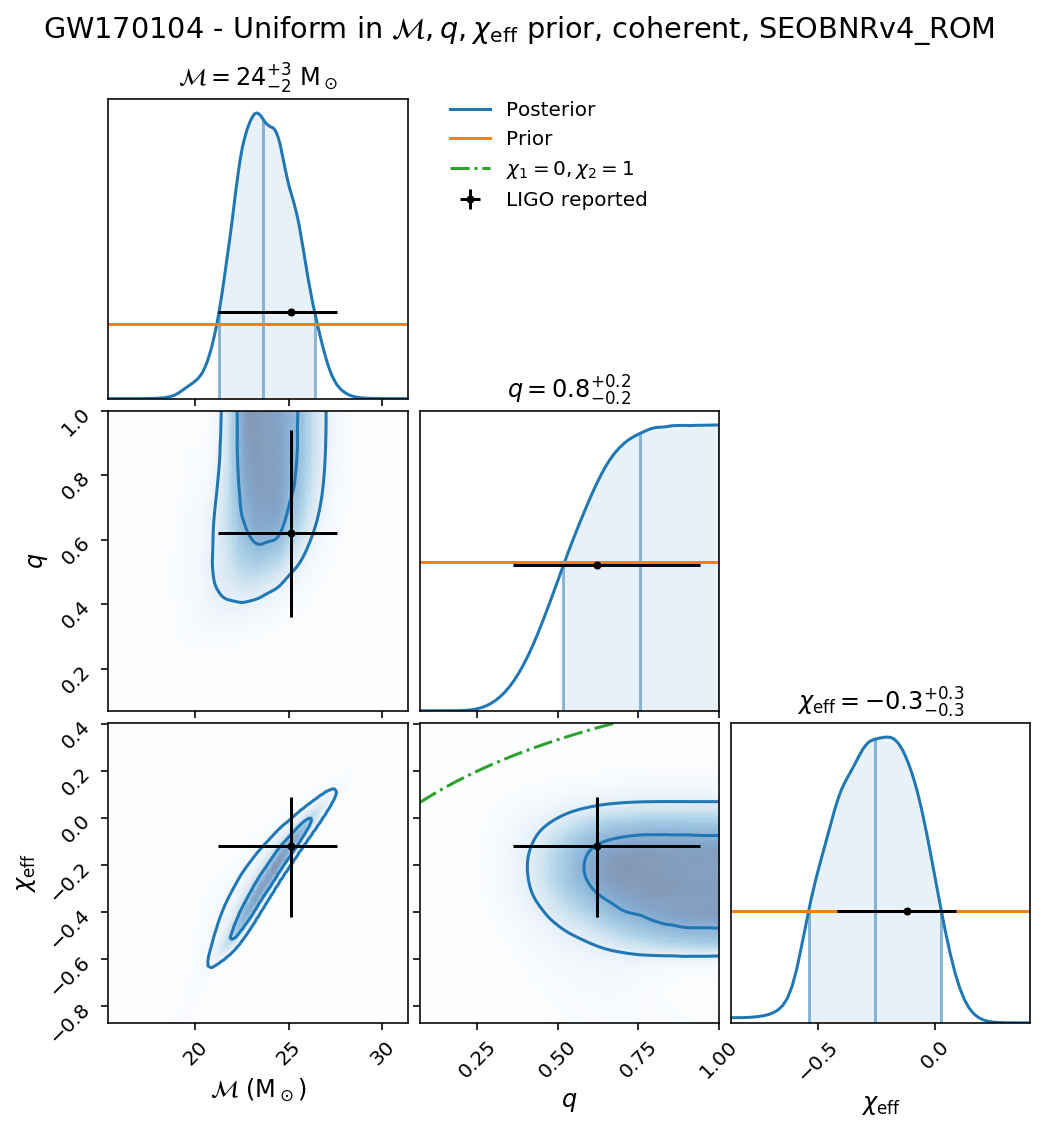

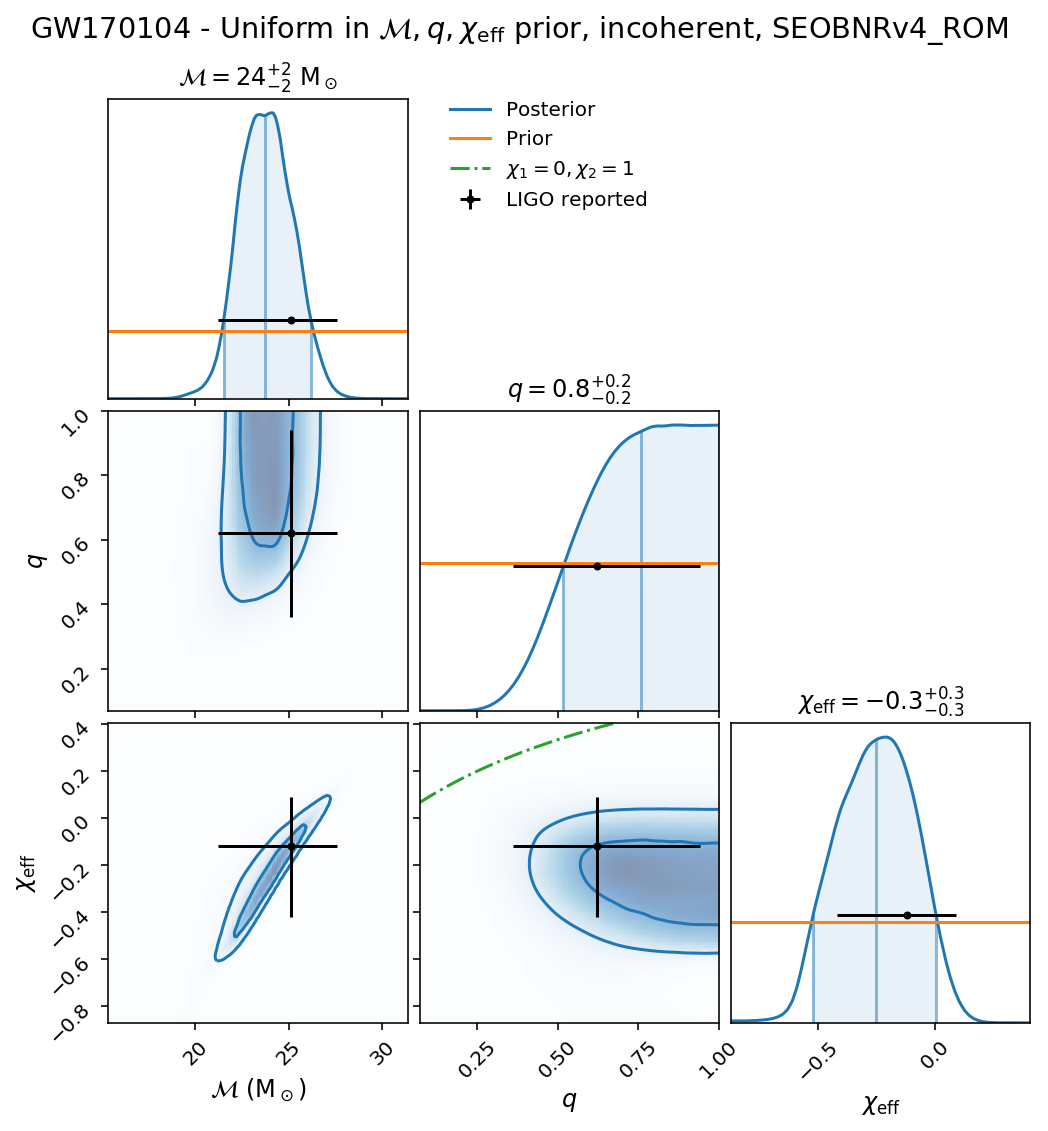

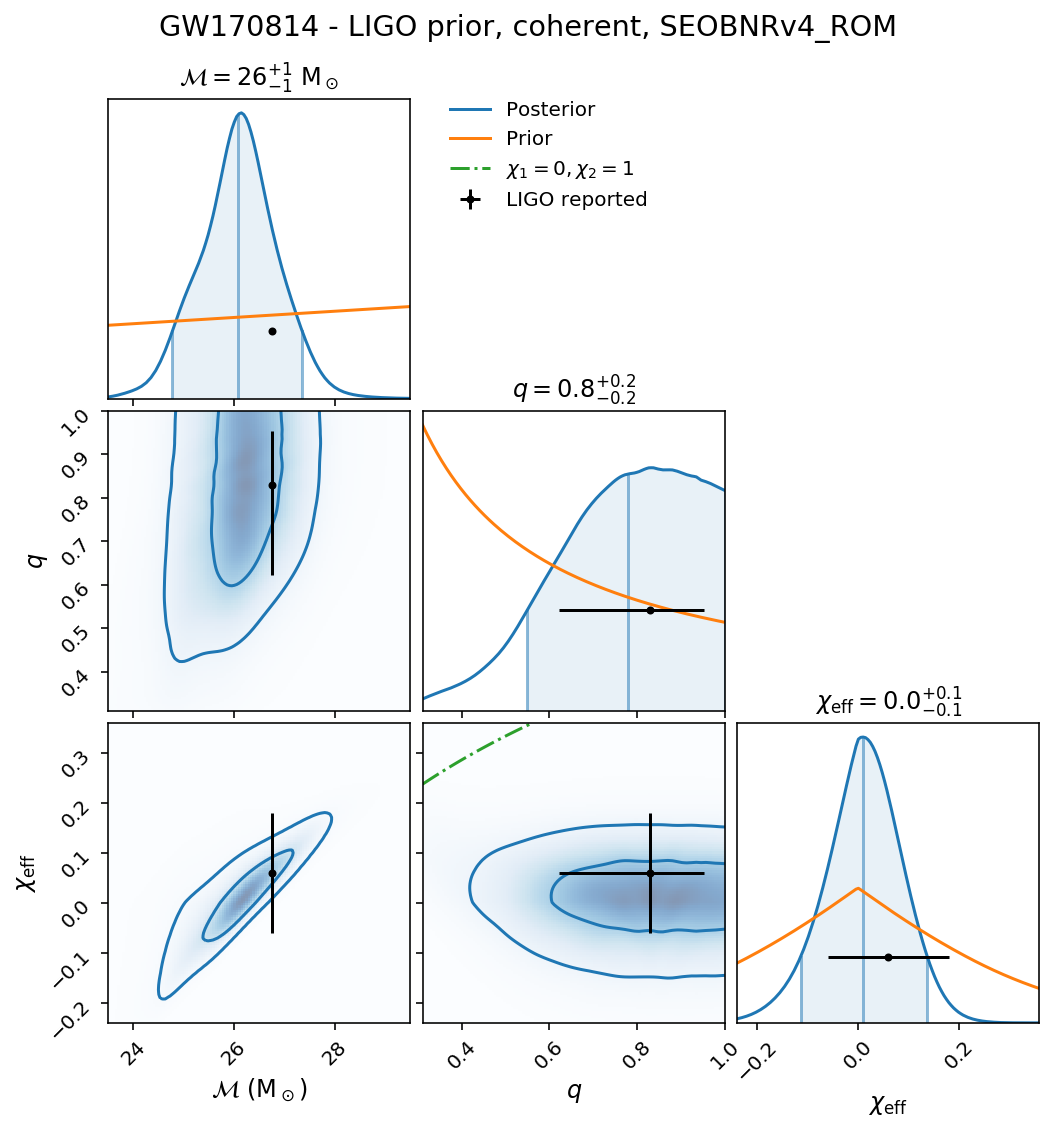

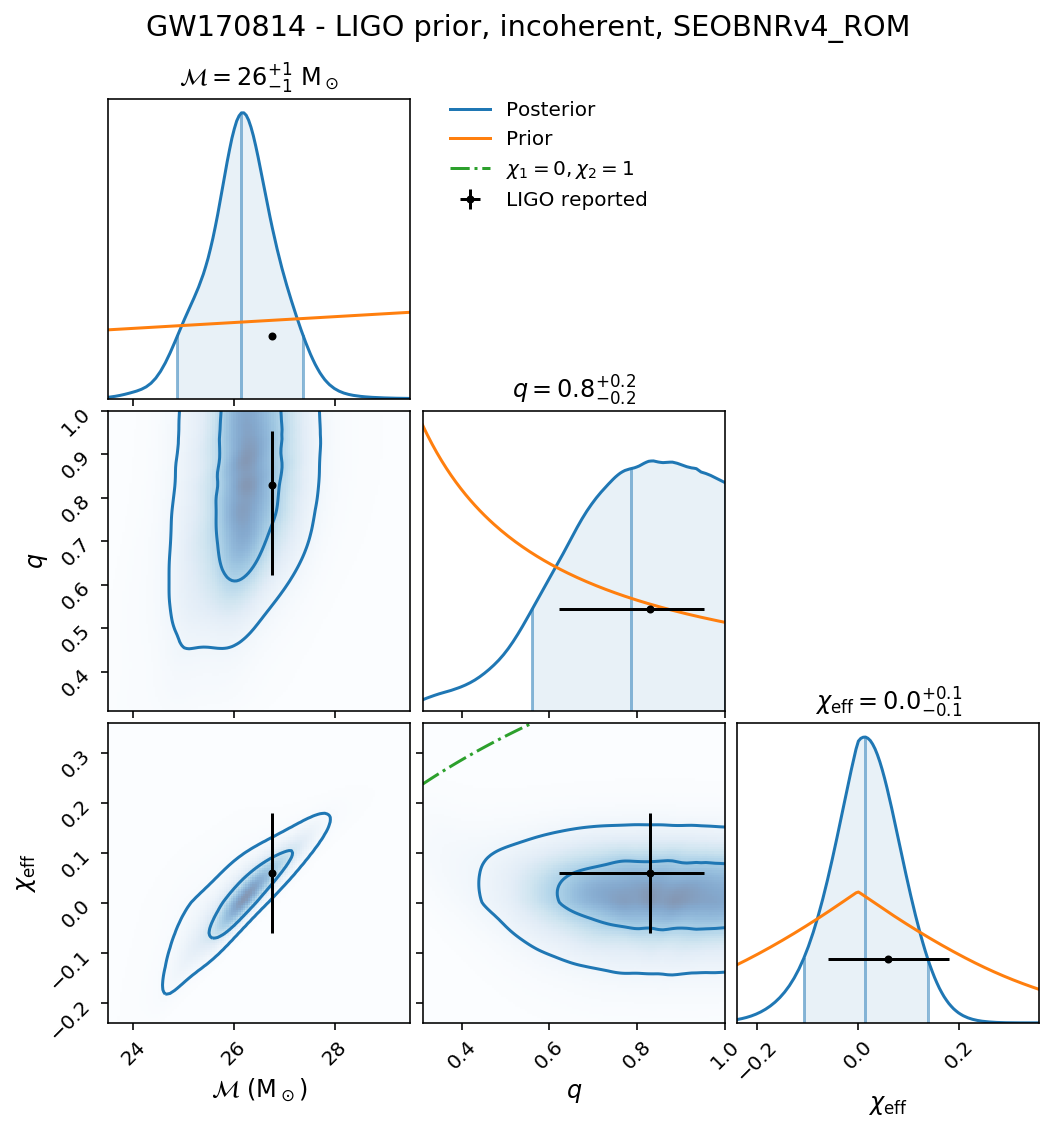

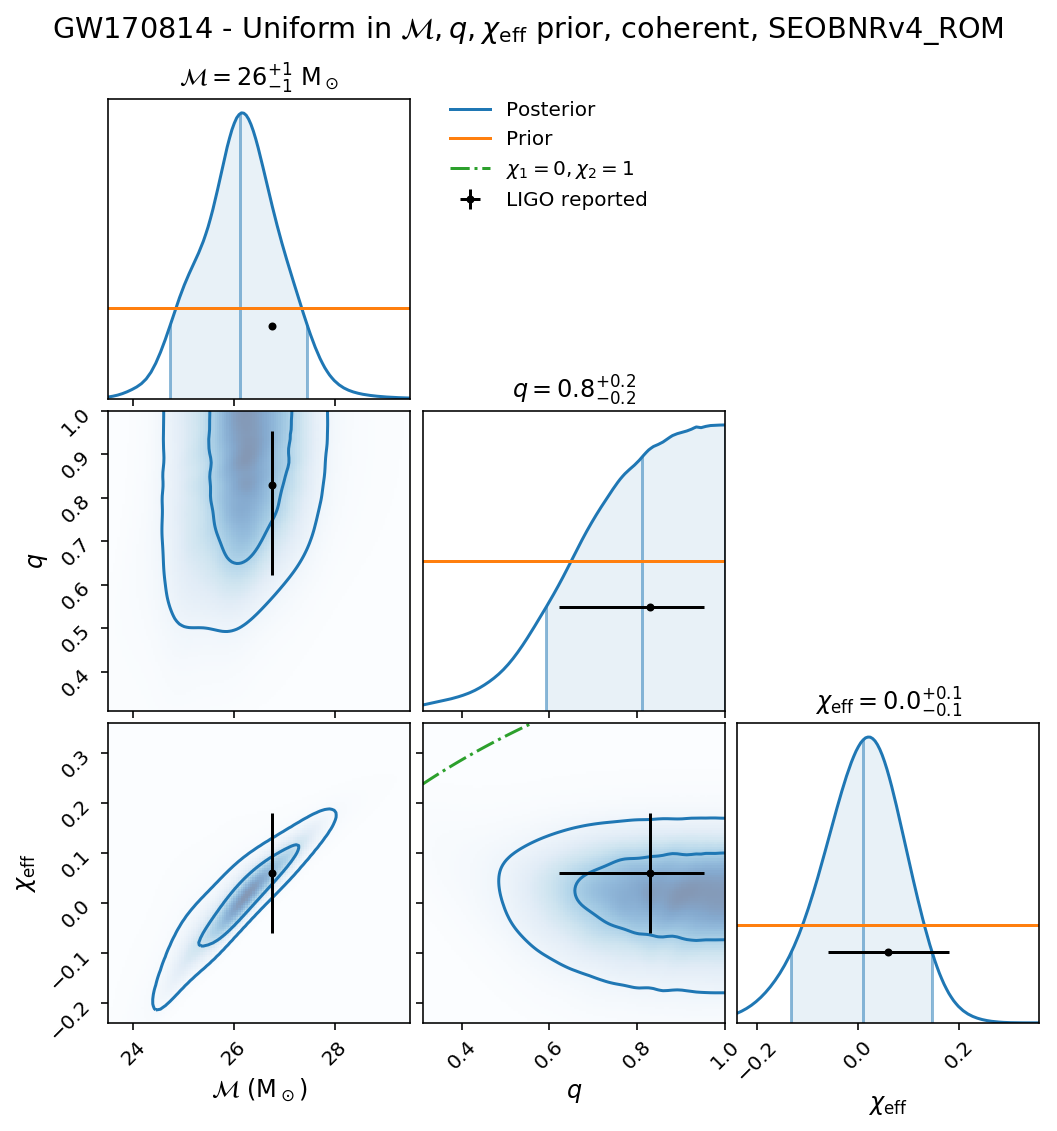

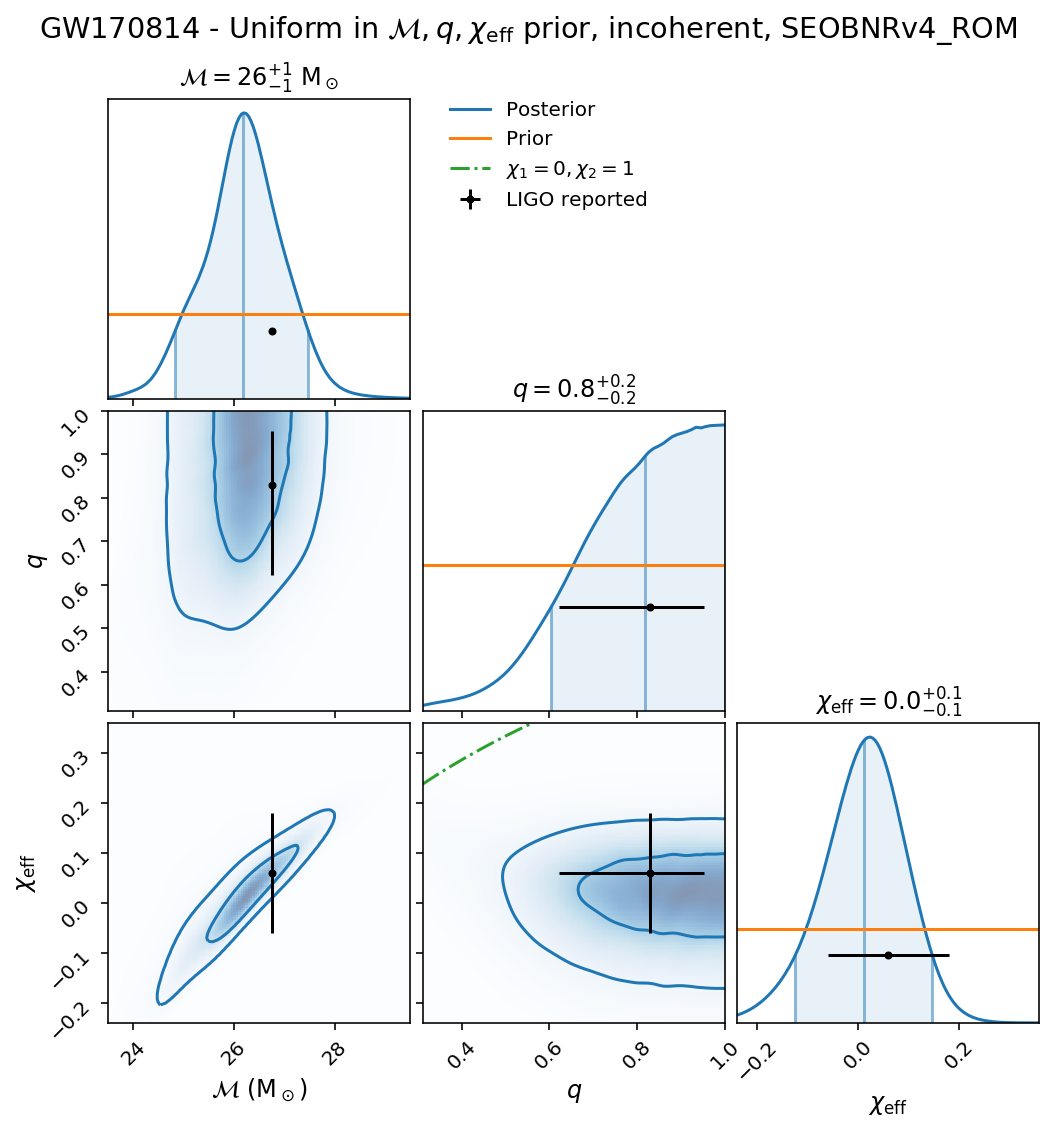

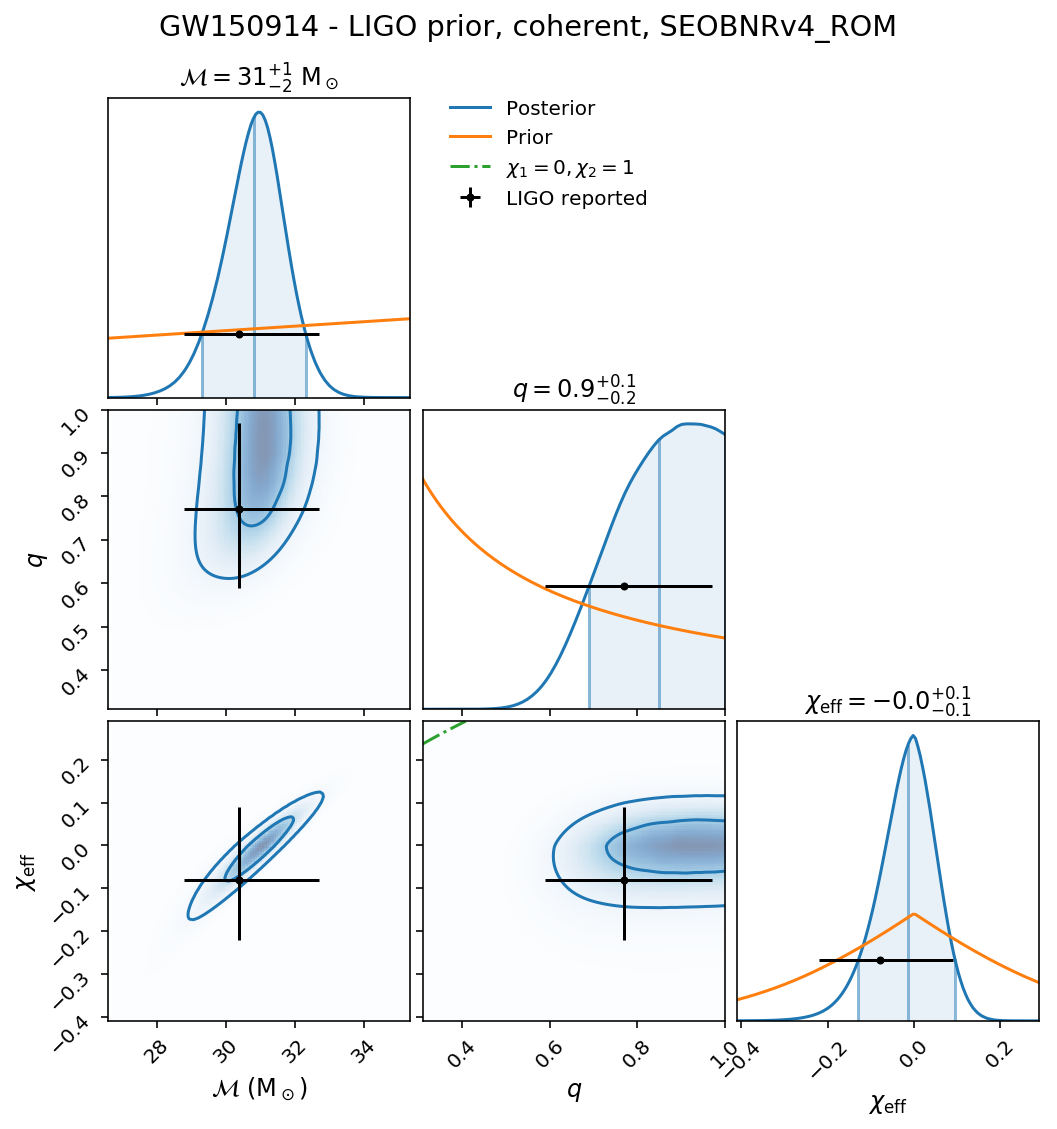

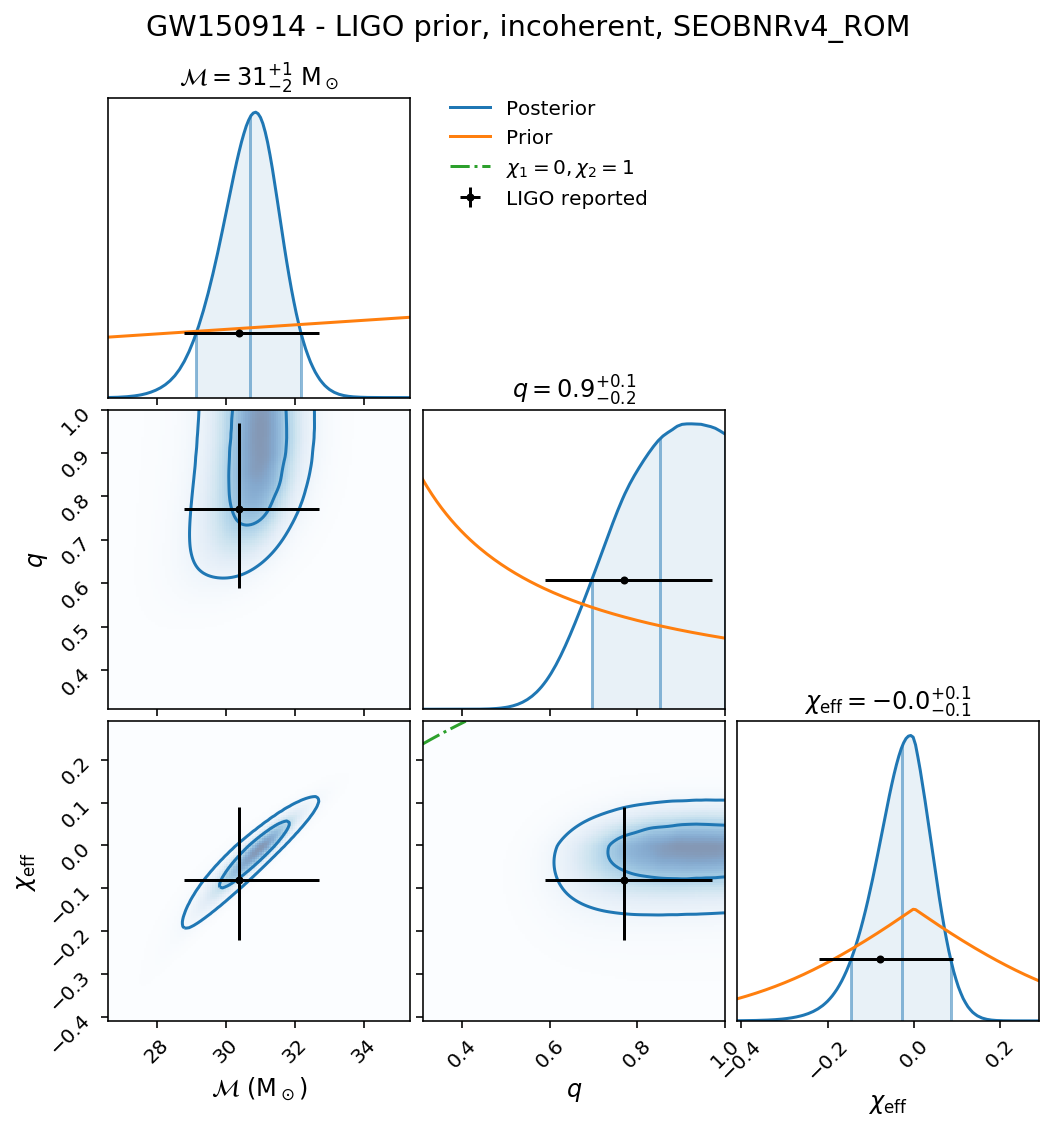

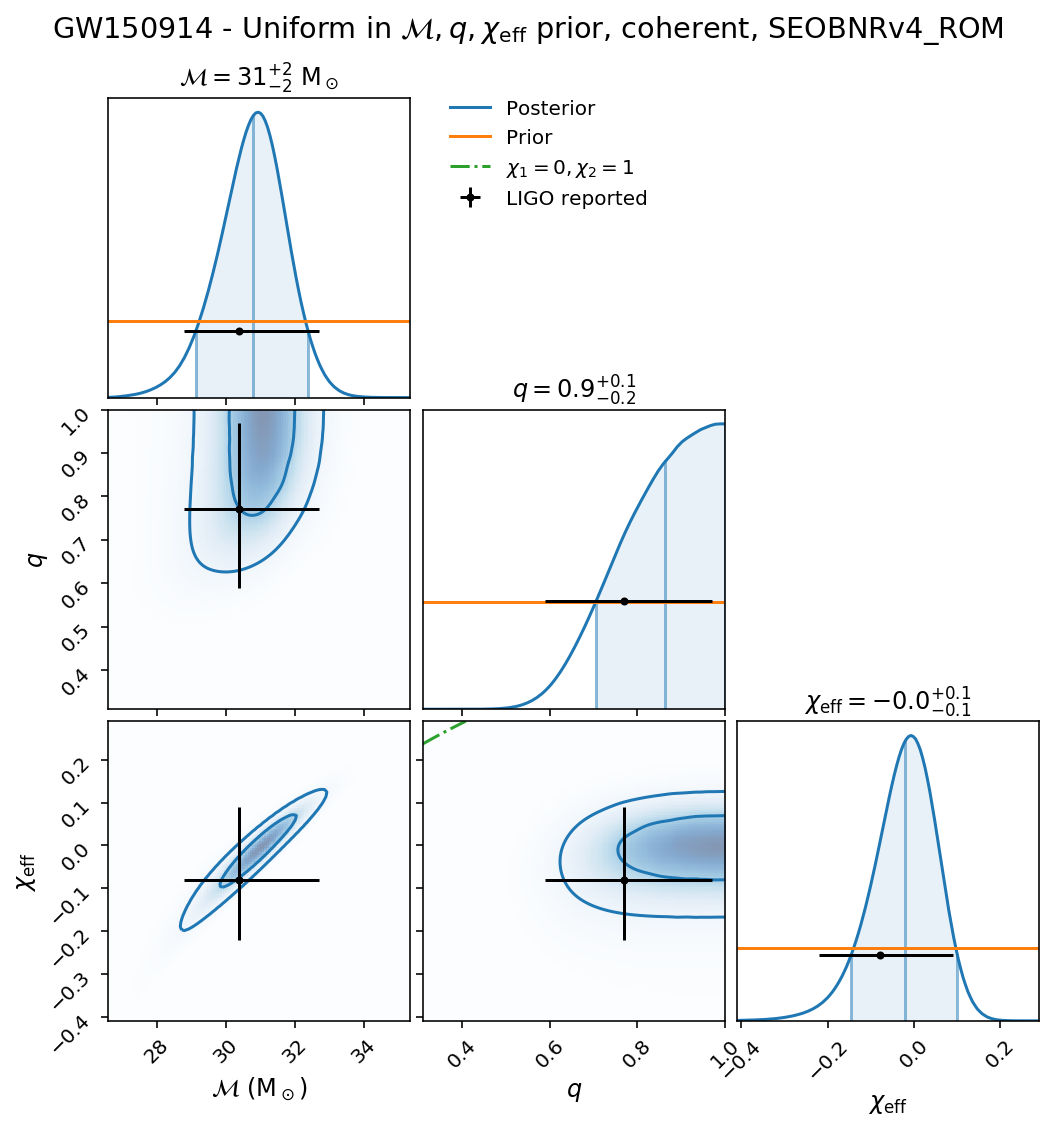

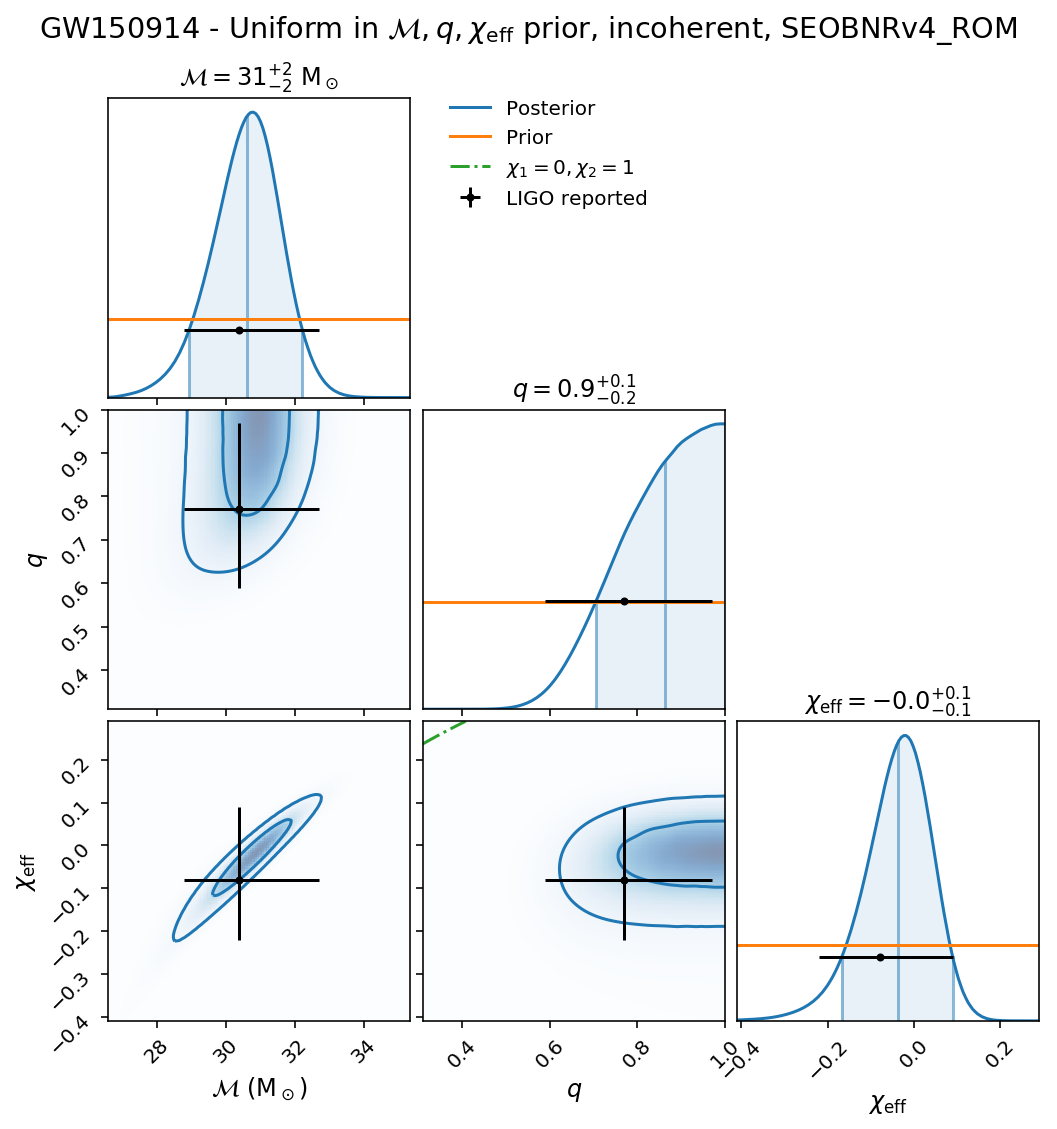

In [19]:
plt.clf();
n_cols = n_rows = len(grid_params)
for event in events:
    for prior in priors:
        for CA in coherences_approximants:
            coherence, approximant = CA
            PCA = [prior.name, (*CA)]
            try:  # Has LIGO reported values for this approximant?:
                ligo_parameters[event][x_par][approximant]
                app = approximant
            except KeyError:  # ... or only Overall?:
                app = 'Overall'

            fig, ax = plt.subplots(n_rows, n_cols, figsize=(2.5 * n_cols, 2.5 * n_rows + .5));
            plt.suptitle('{} - {} prior, {}, {}'.format(event, prior.latex, (*CA)), size='x-large')

            # Plot 2D posteriors (off-diagonal in the plot grid)
            for row, y_par in list(enumerate(grid_params))[1:]:
                for col, x_par in list(enumerate(grid_params))[:row]:
                    plt.sca(ax[row][col])
                    xy_posterior = grid_2d[event][x_par, y_par]['posterior', (*PCA)].T

                    plt.imshow(xy_posterior, extent=[grid_1d[event][x_par].min(), grid_1d[event][x_par].max(),
                                                     grid_1d[event][y_par].min(), grid_1d[event][y_par].max()],
                               cmap='Blues', origin='lower', aspect='auto', alpha=.5)

                    contours = plt.contour(grid_1d[event][x_par], grid_1d[event][y_par], xy_posterior,
                                           levels=levels[event][(*PCA), (x_par, y_par)], colors='C0')
                    #for i in range(len(fractions)):
                    #    contours.collections[i].set_label('{:.0f}% c.l.'.format(100*fractions[i]))

                    if set([x_par, y_par]) == set(['q', 'chi_eff']):
                        try:  # If the locked-secondary curve has support in the 2d plot range
                            plt.plot(locked[event][x_par], locked[event][y_par],
                                     '-.C2', label=r'$\chi_1=0, \chi_2 = 1$')
                        except KeyError:
                            pass
                        ii, jj = row, col  # The row and col of the q-chi_eff plot

                    plt.errorbar(ligo_parameters[event][x_par][app],
                                 ligo_parameters[event][y_par][app],
                                 xerr=[[ligo_parameters[event][x_par][app + '_errm']],
                                       [ligo_parameters[event][x_par][app + '_errp']]],
                                 yerr=[[ligo_parameters[event][y_par][app + '_errm']],
                                       [ligo_parameters[event][y_par][app + '_errp']]],
                                 label='LIGO reported', color='k', ecolor='k', ls='None', fmt='.')

            # Plot 1D posteriors (diagonal)
            for i, par in enumerate(grid_params):
                plt.sca(ax[i][i])
                ligo_val = ligo_parameters[event][par][app]
                ligo_err = [[ligo_parameters[event][par][app + '_errm']],
                            [ligo_parameters[event][par][app + '_errp']]]
                plt.errorbar(ligo_val,
                             np.interp(bounds_estimate[event][(*PCA), par][0],
                                       grid_1d[event][par],
                                       grid_1d[event]['posterior', (*PCA), par]),
                             xerr=ligo_err, ls='None', fmt='.', color='k', ecolor='k', zorder=10)
                for val in [median[event][(*PCA), par], *bounds_estimate[event][(*PCA), par]]:
                    plt.plot([val]*2, [0, np.interp(val, grid_1d[event][par], 
                                                    grid_1d[event]['posterior', (*PCA), par])],
                              'C0', alpha=.5)
                span = np.linspace(*bounds_estimate[event][(*PCA), par])
                plt.fill_between(span, 0, np.interp(span, grid_1d[event][par], 
                                                    grid_1d[event]['posterior', (*PCA), par]), alpha=.1)
                plt.title('{}$=${}{}'.format(latex[par], 
                                             latex_val_err(median[event][(*PCA), par], 
                                                           err_estimate[event][(*PCA), par]),
                                             unit[par].replace('(', '').replace(')','')))
                plt.plot(grid_1d[event][par],
                         grid_1d[event]['posterior', (*PCA), par], label='Posterior')
                plt.plot(grid_1d[event][par], grid_1d[event][prior.name, par], label='Prior')
            # Embellish
            handles_1d, labels_1d = ax[0][0].get_legend_handles_labels()
            handles_2d, labels_2d = ax[ii][jj].get_legend_handles_labels()
            fig.legend(handles_1d + handles_2d, labels_1d + labels_2d, 
                       loc='upper left', bbox_to_anchor=(.4, .91), frameon=False)
            for col, x_par in enumerate(grid_params):
                ax[n_rows-1][col].set_xlabel(latex[x_par] + unit[x_par], size='large')
                plt.setp(ax[n_rows-1][col].get_xticklabels(), rotation=45)
                for row in range(n_rows-1):
                    ax[row][col].tick_params(labelbottom='off')
            for row, y_par in list(enumerate(grid_params))[1:]:
                ax[row][0].set_ylabel(latex[y_par] + unit[y_par], size='large')
                plt.setp(ax[row][0].get_yticklabels(), rotation=45)
                for col in range(1, n_cols):
                    ax[row][col].tick_params(labelleft='off')
            for row in range(n_rows-1):
                for col in range(row+1, n_cols):
                    ax[row][col].axis('off')
            for col in range(n_cols):
                for row in range(1, n_rows):
                    ax[0][col].get_shared_x_axes().join(ax[0][col], ax[row][col])
                    ax[row][col].autoscale()
            for row in range(n_rows):
                for col in range(1, row):
                    ax[row][0].get_shared_y_axes().join(ax[row][0], ax[row][col])
                    ax[row][col].autoscale()
            for i in range(len(grid_params)):
                ax[i][i].tick_params(axis='y', left='off', labelleft='off')
                ax[i][i].set_ylim(ymin=0)
            ax[-1][-1].set_xlim(grid_1d[event][grid_params[-1]].min(), grid_1d[event][grid_params[-1]].max())
            plt.tight_layout(rect=[0, 0, 1, 0.96]);
            plt.subplots_adjust(hspace=0.04, wspace=0.04);

            plt.savefig('{0}/figures/{0}_{1}.pdf'.format(event, '_'.join(PCA)), bbox_inches='tight')
            plt.show()

#### Prior, likelihood and posterior

In [20]:
class AnyObject(object):
    pass
class AnyObjectHandler(object):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        width, height = handlebox.width, handlebox.height
        patch = mpatches.Rectangle([x0, y0], width, height, facecolor='gainsboro',
                                   edgecolor=None,# hatch='|  ', lw=2,
                                   transform=handlebox.get_transform())
        handlebox.add_artist(patch)
        return patch
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        patch = mpatches.Rectangle([xdescent+width/4 + 8, ydescent-1.3], width/2, height+2.6, facecolor='gainsboro',
                                   edgecolor=None,
                                   transform=trans)
        return [patch]

class HandlerXoffset(HandlerLine2D):
    def __init__(self, marker_pad=0.3, numpoints=1, x_offset=0,  **kw):
        HandlerLine2D.__init__(self, marker_pad=marker_pad, numpoints=numpoints, **kw)
        self._xoffset = x_offset
    def get_xdata(self, legend, xdescent, ydescent, width, height, fontsize):
        numpoints = self.get_numpoints(legend)

        if numpoints > 1:
            # we put some pad here to compensate the size of the
            # marker
            xdata = np.linspace(-xdescent + self._marker_pad * fontsize,
                                width - self._marker_pad * fontsize,
                                numpoints) - self._xoffset
            xdata_marker = xdata
        elif numpoints == 1:
            xdata = np.linspace(-xdescent, width, 2) - self._xoffset
            xdata_marker = [0.5 * width - 0.5 * xdescent - self._xoffset]
        return xdata, xdata_marker

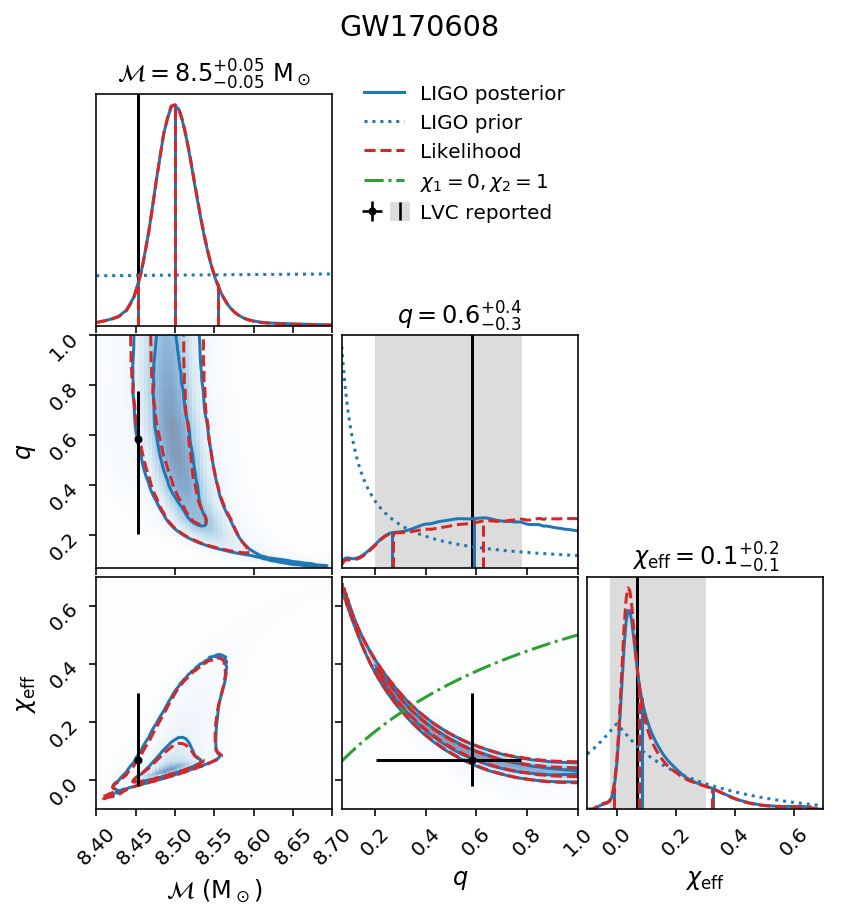

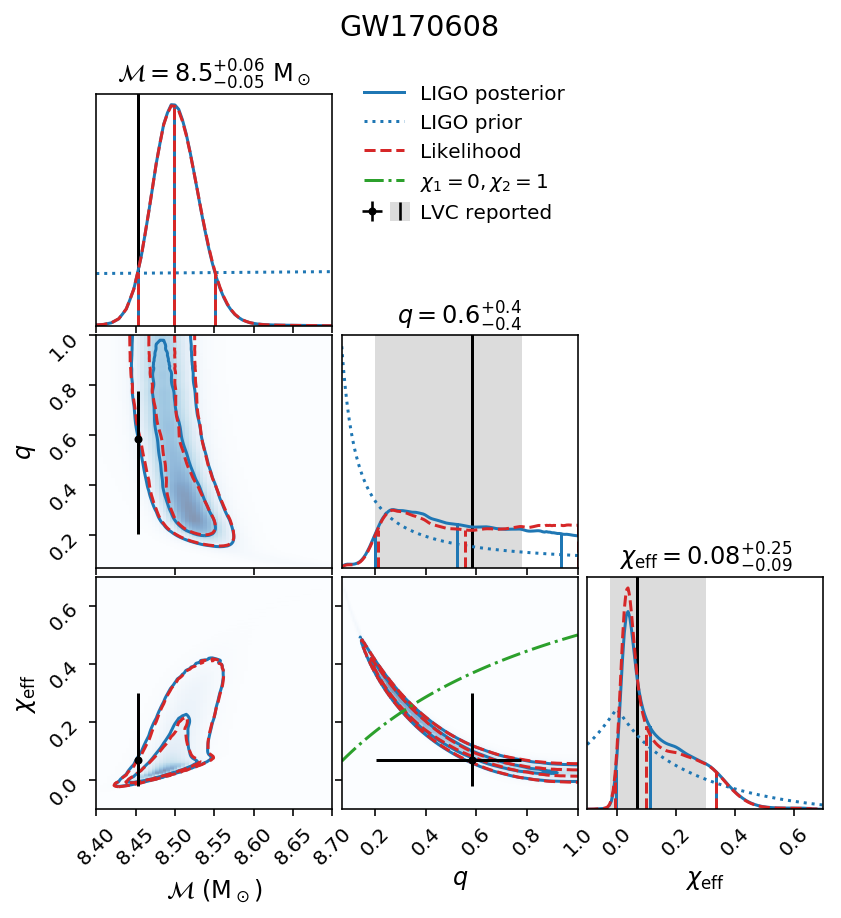

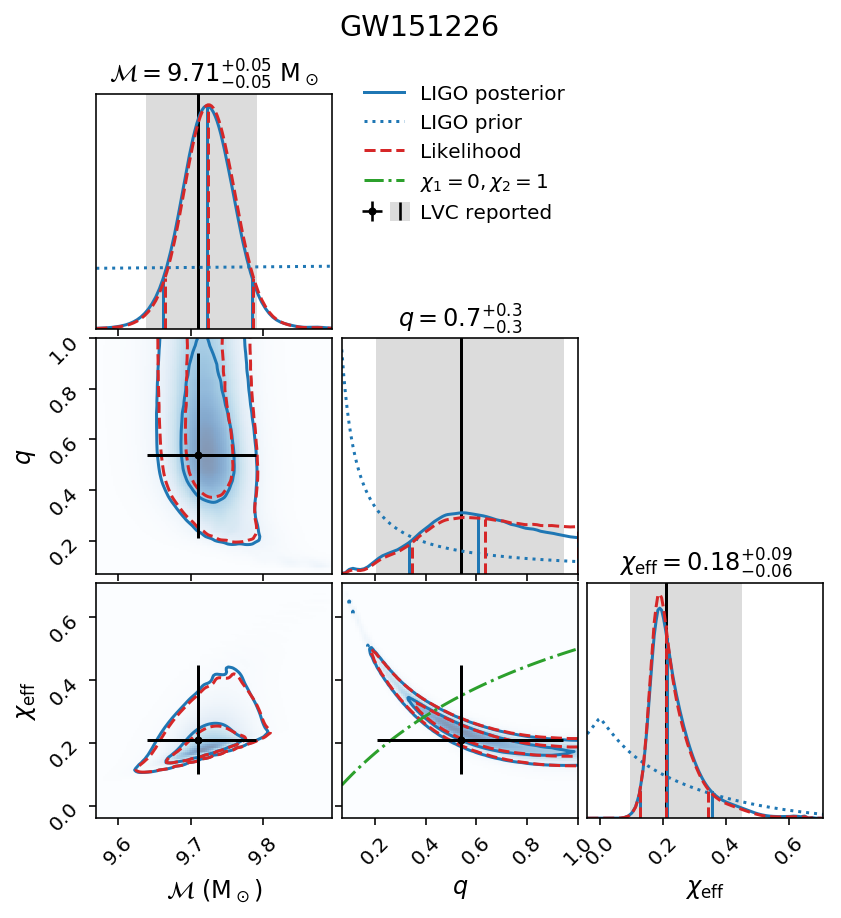

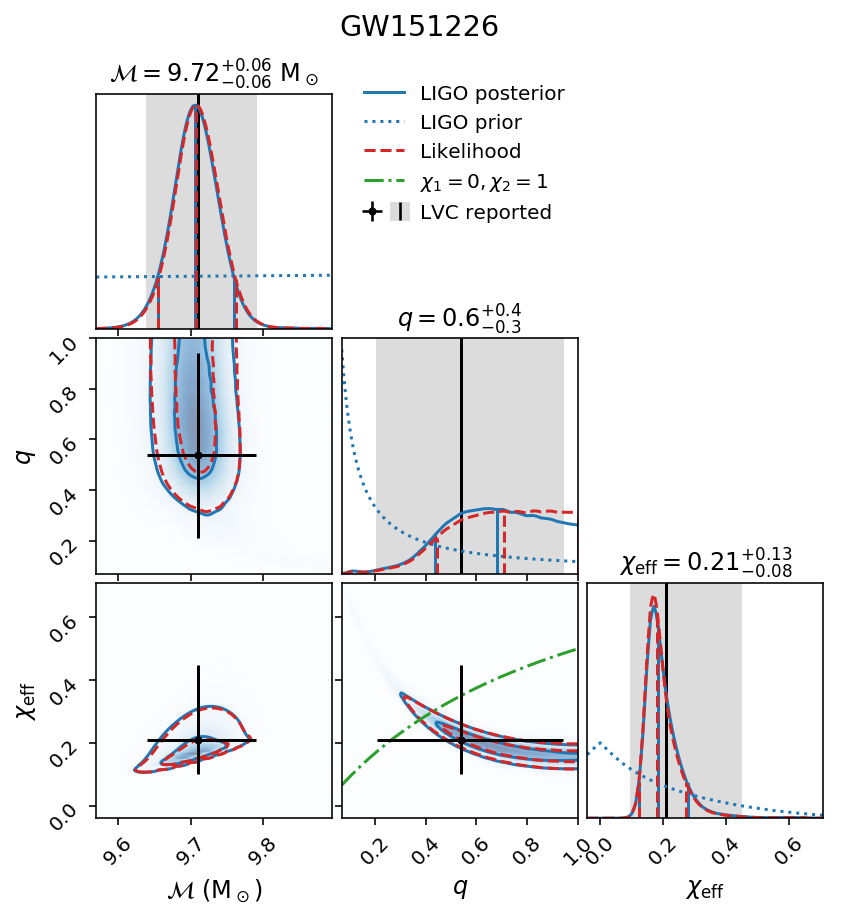

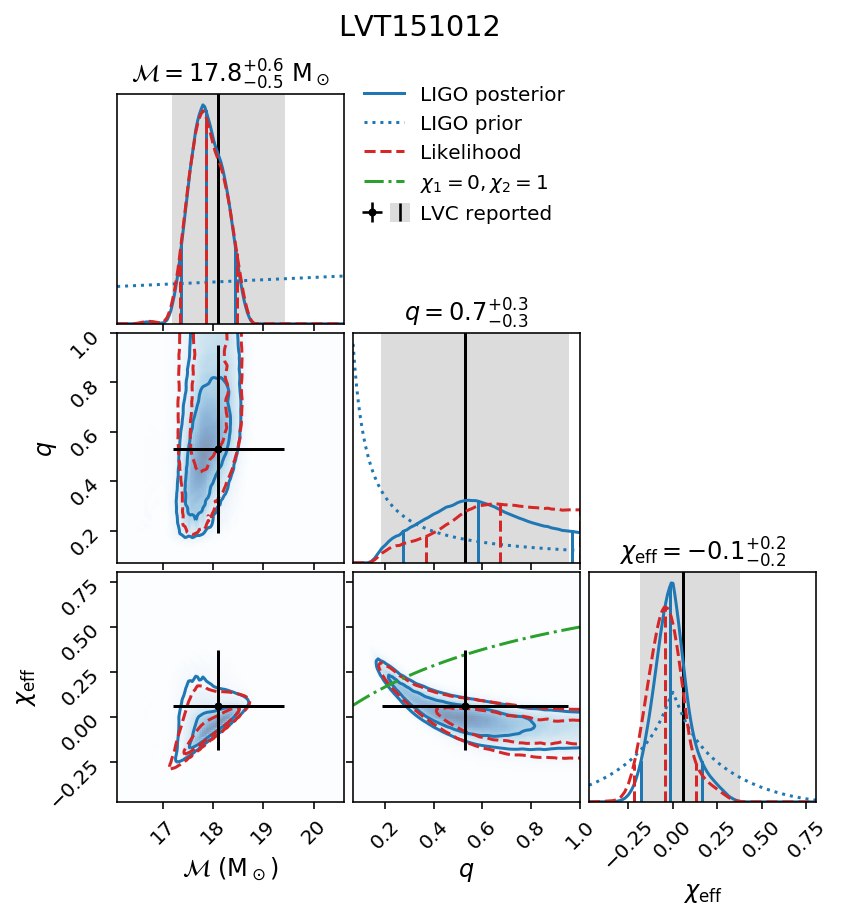

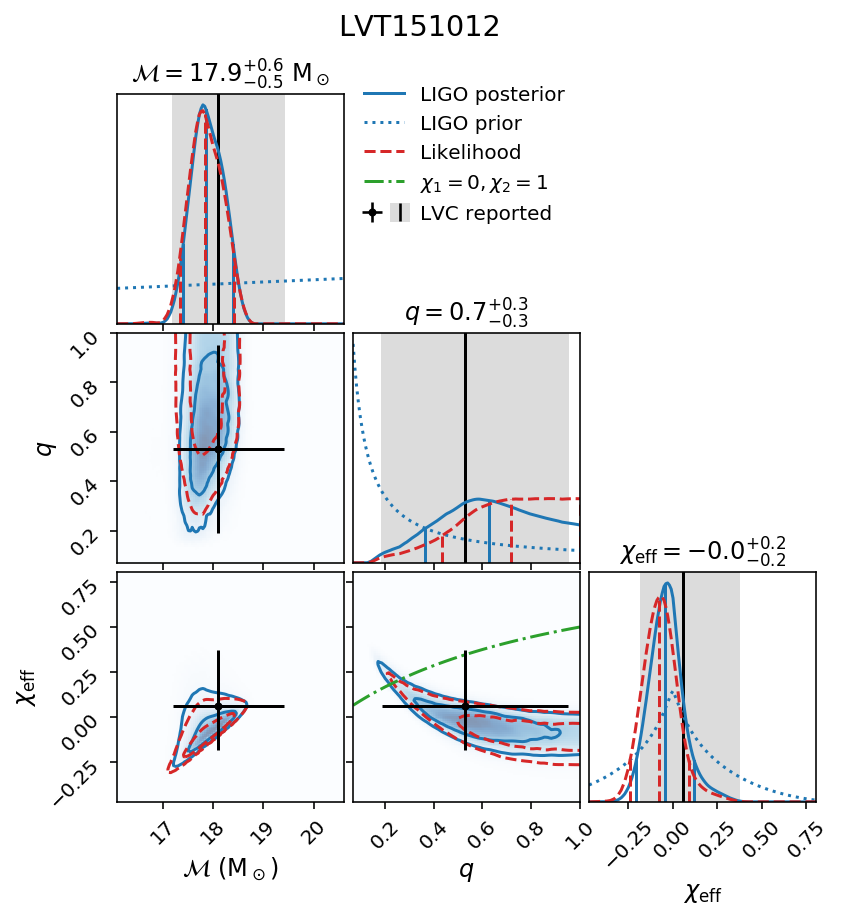

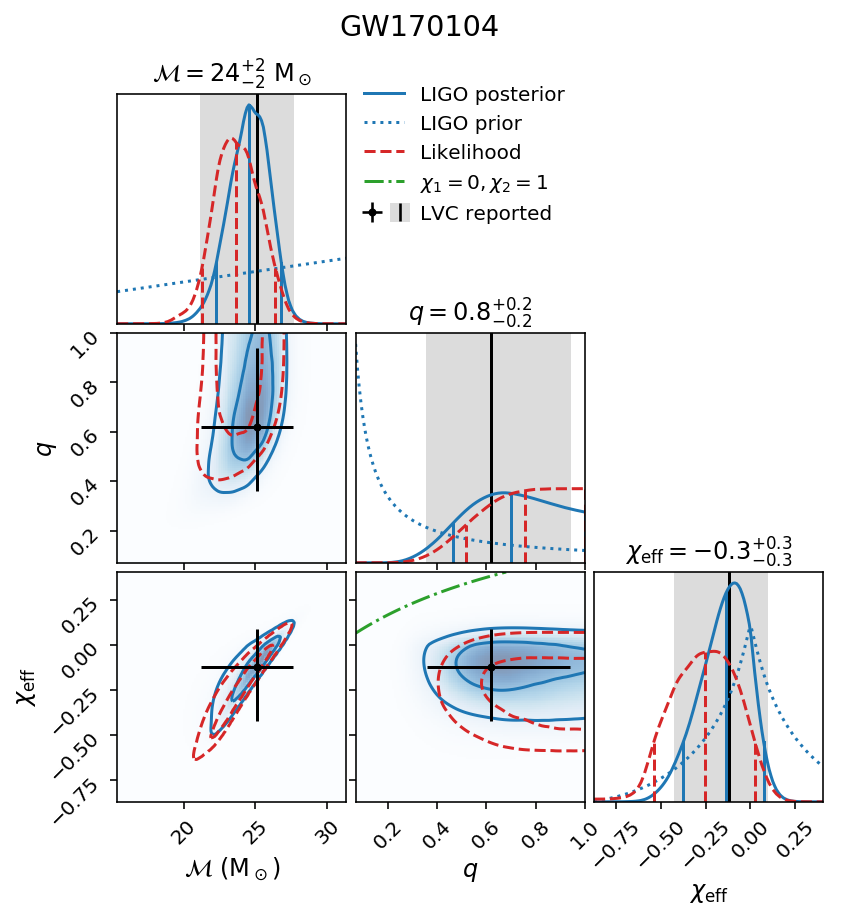

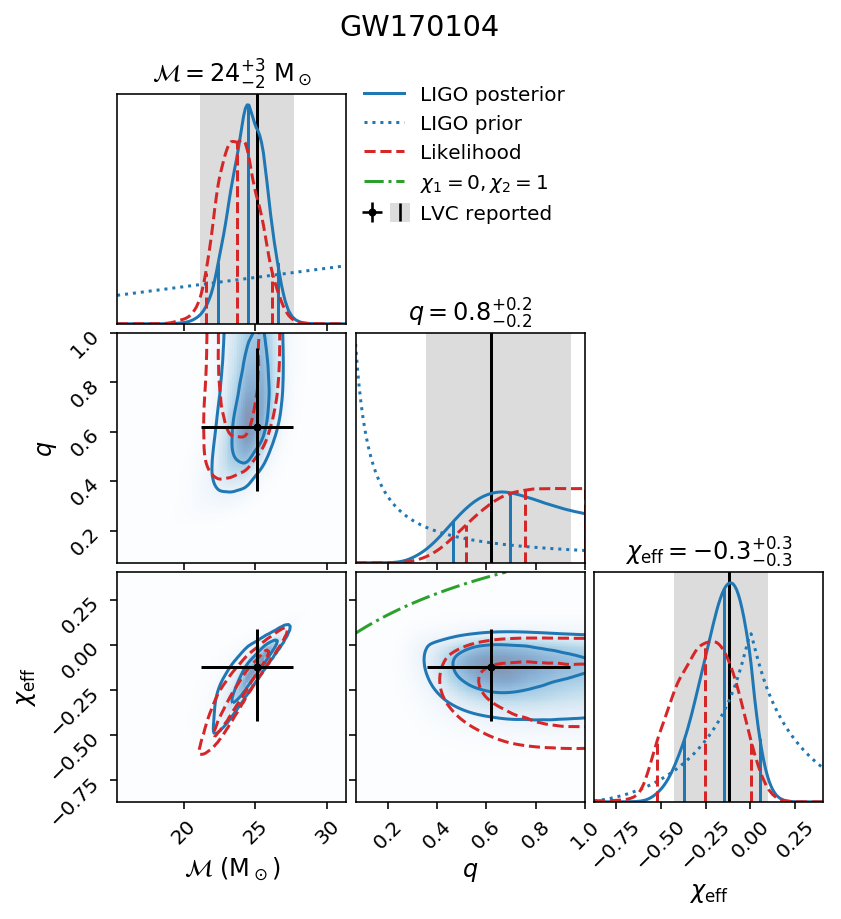

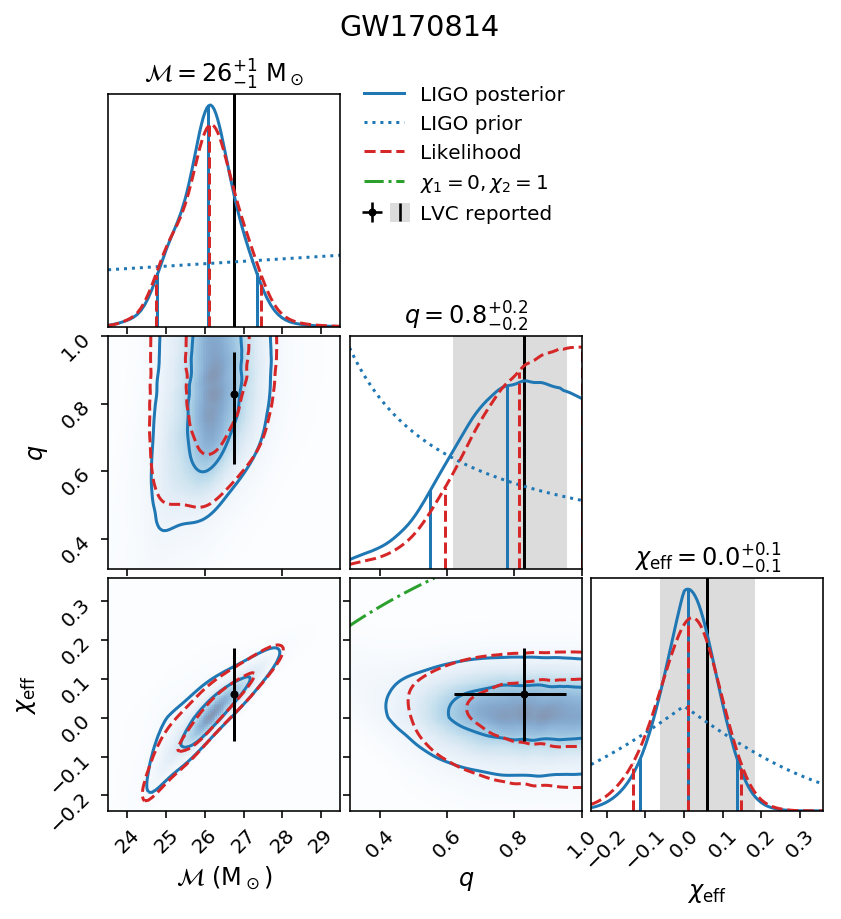

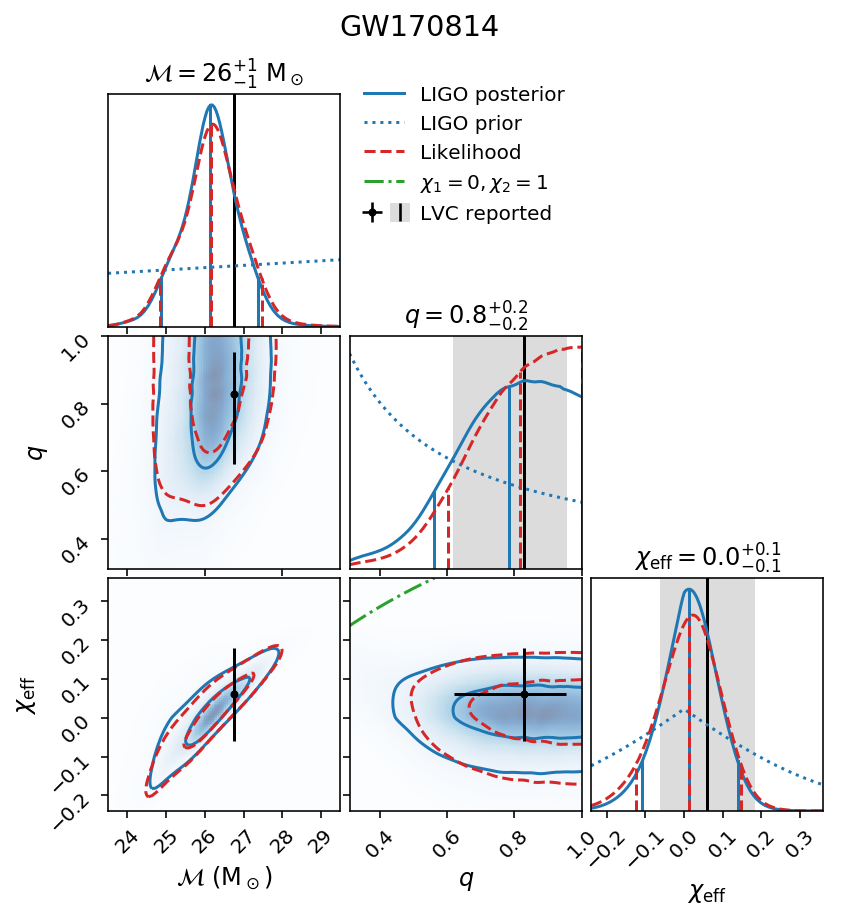

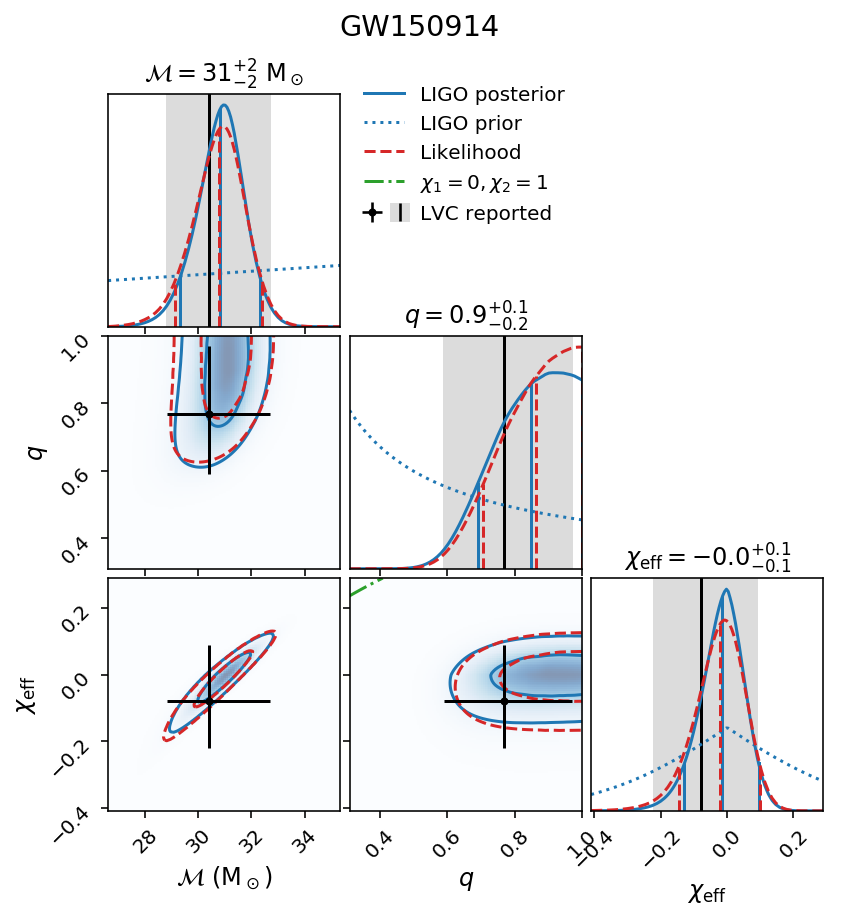

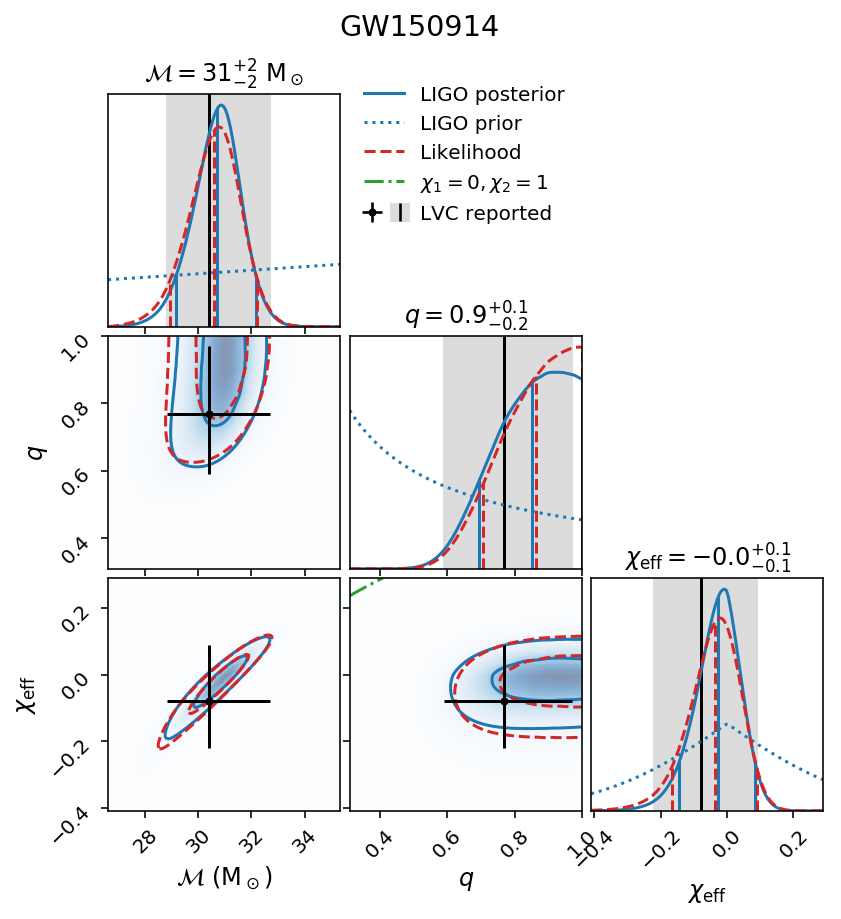

In [21]:
plot_priors = [LIGO_prior, uniform_in_Mchirp_q_chieff]
plotted_posterior = LIGO_prior.name
assert all(pp in priors for pp in plot_priors)
kwargs = {('uniform_in_Mchirp_q_chieff', 'prior'): {'ls': 'none', 'label': '_nolegend_', 'c': 'k'},
          ('uniform_in_Mchirp_q_chieff', 'posterior'): {'ls': '--', 'label': 'Likelihood', 'c': 'C3'},
          ('LIGO_prior', 'prior'): {'ls': ':', 'label': 'LIGO prior', 'c': 'C0'},
          ('LIGO_prior', 'posterior'): {'ls': '-', 'label': 'LIGO posterior', 'c': 'C0'}
         }
assert all(pp in priors for pp in plot_priors)

plt.clf();
n_cols = n_rows = len(grid_params)
for event in events:
    for CA in coherences_approximants:
        coherence, approximant = CA
        try:  # Has LIGO reported values for this approximant?:
            ligo_parameters[event][x_par][approximant]
            app = approximant
        except KeyError:  # ... or only Overall?:
            app = 'Overall'
        fig, ax = plt.subplots(n_rows, n_cols, figsize=(2 * n_cols, 2 * n_rows + .5));
        plt.suptitle('{}'.format(event), size='x-large')
        
        # Plot 2D posteriors (off-diagonal in the plot grid)
        for row, y_par in list(enumerate(grid_params))[1:]:
            for col, x_par in list(enumerate(grid_params))[:row]:
                plt.sca(ax[row][col])
                if set([x_par, y_par]) == set(['q', 'chi_eff']):
                    try:  # If the locked-secondary curve has support in the 2d plot range
                        locked2nd, = plt.plot(locked[event][x_par], locked[event][y_par],
                                 'C2-.', label=r'$\chi_1=0, \chi_2 = 1$')
                    except KeyError:
                        pass
                    ii, jj = row, col  # The row and col of the q-chi_eff plot
                plt.errorbar(ligo_parameters[event][x_par][app],
                             ligo_parameters[event][y_par][app],
                             xerr=[[ligo_parameters[event][x_par][app + '_errm']],
                                   [ligo_parameters[event][x_par][app + '_errp']]],
                             yerr=[[ligo_parameters[event][y_par][app + '_errm']],
                                   [ligo_parameters[event][y_par][app + '_errp']]],
                             label='LIGO reported', color='k', ecolor='k', ls='None', fmt='.', zorder=10)
                xy_posterior = grid_2d[event][x_par, y_par]['posterior', plotted_posterior, (*CA)].T
                plt.imshow(xy_posterior, extent=[grid_1d[event][x_par].min(), grid_1d[event][x_par].max(),
                                                 grid_1d[event][y_par].min(), grid_1d[event][y_par].max()],
                           cmap='Blues', origin='lower', aspect='auto', alpha=.5)
        # Plot 1D posteriors (diagonal)
        for i, par in enumerate(grid_params):
            plt.sca(ax[i][i])
            ligo_val = ligo_parameters[event][par][app]
            ligo_err = [[ligo_parameters[event][par][app + '_errm']],
                        [ligo_parameters[event][par][app + '_errp']]]
            
            #plt.errorbar(ligo_val, np.interp(bounds_estimate[event][(*PCA), par][0],
            #                                 grid_1d[event][par],
            #                                 grid_1d[event]['posterior', (*PCA), par]),
            #             xerr=ligo_err, ls='None', fmt='.', color='k', ecolor='k', zorder=10)
            
            vline, = plt.plot([],[], marker='|', ls = '', mew=1.3, markersize=9.3, c='k')
            plt.axvline(ligo_val, c='k', zorder=-20)
            plt.axvspan(ligo_val - ligo_err[0], ligo_val + ligo_err[1], color='gainsboro', zorder=-21)
            
            plt.title('{}$=${}{}'.format(latex[par], 
                                         latex_val_err(median[event][(*PCA), par], 
                                                       err_estimate[event][(*PCA), par]),
                                         unit[par].replace('(', '').replace(')','')))
        
        for prior in priors:
            PCA = [prior.name, (*CA)]
            # Plot 2D posteriors (off-diagonal in the plot grid)
            for row, y_par in list(enumerate(grid_params))[1:]:
                for col, x_par in list(enumerate(grid_params))[:row]:
                    plt.sca(ax[row][col])
                    xy_posterior = grid_2d[event][x_par, y_par]['posterior', (*PCA)].T
                    contours = plt.contour(grid_1d[event][x_par], grid_1d[event][y_par], xy_posterior,
                                           levels=levels[event][(*PCA), (x_par, y_par)],
                                           colors=kwargs[prior.name, 'posterior']['c'],
                                           linestyles=kwargs[prior.name, 'posterior']['ls'])

            # Plot 1D posteriors (diagonal)
            for i, par in enumerate(grid_params):
                plt.sca(ax[i][i])
                for val in [median[event][(*PCA), par], *bounds_estimate[event][(*PCA), par]]:
                    plt.plot([val]*2, [0, np.interp(val, grid_1d[event][par], 
                                                    grid_1d[event]['posterior', (*PCA), par])],
                             **{k: kwargs[prior.name, 'posterior'][k] for k in ['c', 'ls']})
                plt.plot(grid_1d[event][par],
                         grid_1d[event]['posterior', (*PCA), par], **kwargs[prior.name, 'posterior'])
                plt.plot(grid_1d[event][par], grid_1d[event][prior.name, par], **kwargs[prior.name, 'prior'])
        # Embellish
        handles_1d, labels_1d = ax[0][0].get_legend_handles_labels()
        errpoint = mlines.Line2D([], [], marker='.', color='k', ls='None')
        errbars = mlines.Line2D([],[], marker='+', mew=1.3, markersize=10, color='k', ls='None')
        #handles_2d, labels_2d = ax[ii][jj].get_legend_handles_labels()
        fig.legend(handles_1d + [locked2nd, (errpoint, errbars, (AnyObject(), vline))],
                   labels_1d + [r'$\chi_1=0, \chi_2 = 1$'] + ['LVC reported'], 
                   loc='upper left', bbox_to_anchor=(.4, .91), frameon=False,
                   handler_map={AnyObject: AnyObjectHandler(), vline:HandlerXoffset(x_offset=-8),
                               errpoint:HandlerXoffset(x_offset=6), errbars:HandlerXoffset(x_offset=6)})
        for col, x_par in enumerate(grid_params):                                    # Set x labels & ticks
            ax[n_rows-1][col].set_xlabel(latex[x_par] + unit[x_par], size='large')
            plt.setp(ax[n_rows-1][col].get_xticklabels(), rotation=45)
            ax[n_rows-1][col].locator_params(nbins=6)
            for row in range(n_rows-1):
                ax[row][col].tick_params(labelbottom='off')
        for row, y_par in list(enumerate(grid_params))[1:]:                          # Set y labels & ticks
            ax[row][0].set_ylabel(latex[y_par] + unit[y_par], size='large')
            plt.setp(ax[row][0].get_yticklabels(), rotation=45)
            for col in range(1, n_cols):
                ax[row][col].tick_params(labelleft='off')
        for row in range(n_rows-1):                                                  # Disable upper triangle
            for col in range(row+1, n_cols):
                ax[row][col].axis('off')
        for col in range(n_cols):                                                    # Share x axes
            for row in range(0, n_rows-1):
                ax[0][col].get_shared_x_axes().join(ax[n_rows-1][col], ax[row][col])
                ax[row][col].set_xticks(ax[n_rows-1][col].get_xticks())
                ax[row][col].autoscale()
        for row in range(1, n_rows):                                                 # Share y axes
            for col in range(1, row):
                ax[row][0].get_shared_y_axes().join(ax[row][0], ax[row][col])
                ax[row][col].set_yticks(ax[row][0].get_yticks())
                ax[row][col].autoscale()
        for i in range(len(grid_params)):                                            # Diagonal plots
            ax[i][i].tick_params(axis='y', left='off', labelleft='off')
            ax[i][i].set_ylim(ymin=0)
        ax[-1][-1].set_xlim(grid_1d[event][grid_params[-1]].min(), grid_1d[event][grid_params[-1]].max())
        plt.tight_layout(rect=[0, 0, 1, 0.96]);
        plt.subplots_adjust(hspace=0.04, wspace=0.04);

        plt.savefig('{0}/figures/{0}_changing_priors_{1}.pdf'.format(event, '_'.join(CA)), bbox_inches='tight')
        plt.show()

### Multi-event plots
#### Single prior

#### With X-ray binaries

In [22]:
class HandlerEllipse(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = mpatches.Ellipse(xy=center, width=width + xdescent,
                             height=height + ydescent)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

In [23]:
persistents_data = [
    ['Cyg X-1', 1, .05, 14.8, 1],
    ['LMC X-1', .91, .06, 10.9, 1.4],
    ['M33 X-1', .84, .05, 15.65, 1.45]]
transients_data = [
    ['GRS 1915+105', 1, .05, 10.1, .6],
    ['4U 1543-47', .8, .1, 9.4, 1],
    ['GRO J1655–40', .7, .1, 6.3, .5],
    ['XTE J1550–564', .3, .24, 9.1, .6],
    #['H1743–322', .2, .3, 8, 1],
    ['LMC X-3', .15, .15, 7.6, 1.6],
    ['A0620–00', .12, .19, 6.6, .25]]

persistents = pd.DataFrame(persistents_data,
                           columns=['name', 'a', 'a_err', 'M', 'M_err'])
transients = pd.DataFrame(transients_data,
                           columns=['name', 'a', 'a_err', 'M', 'M_err'])

LIGO


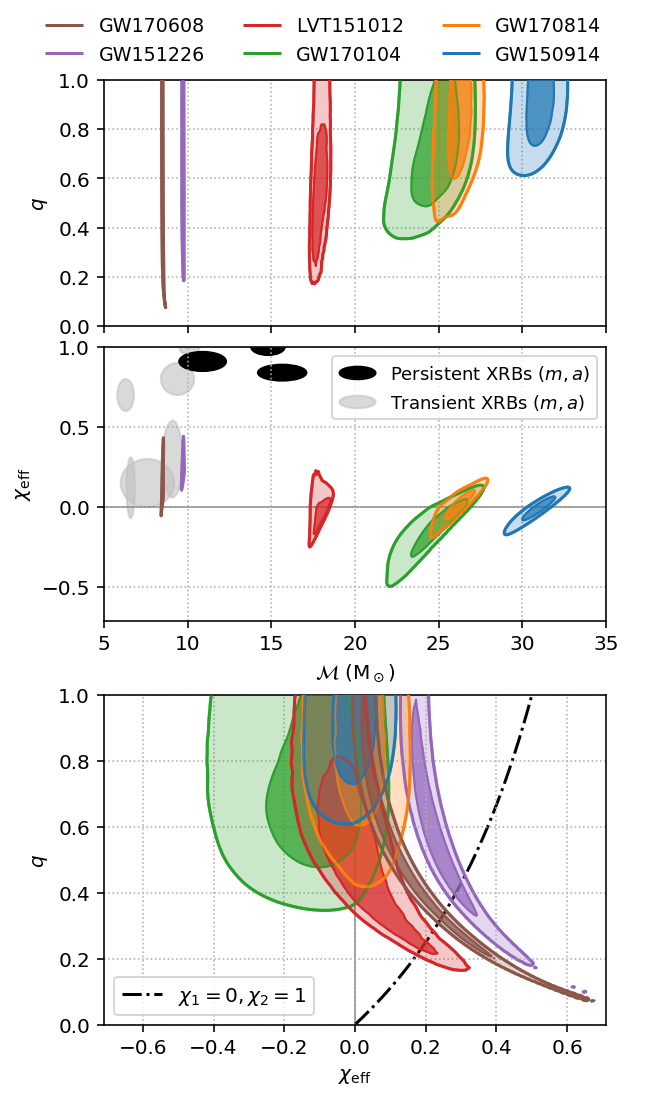

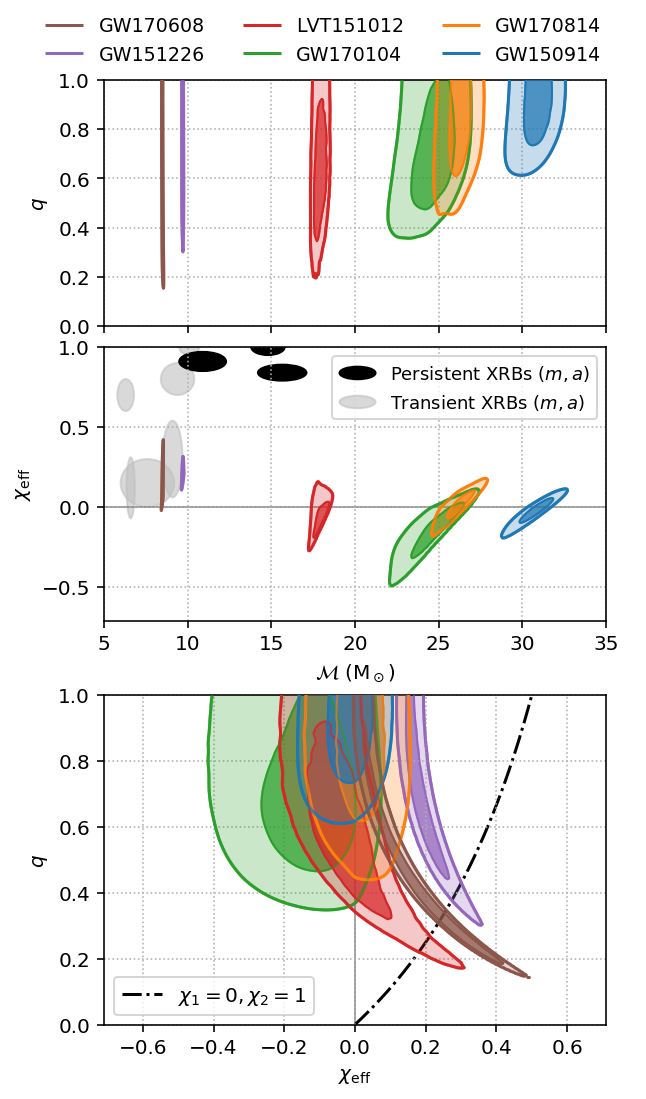

Uniform in Mchirp, q, Xeff


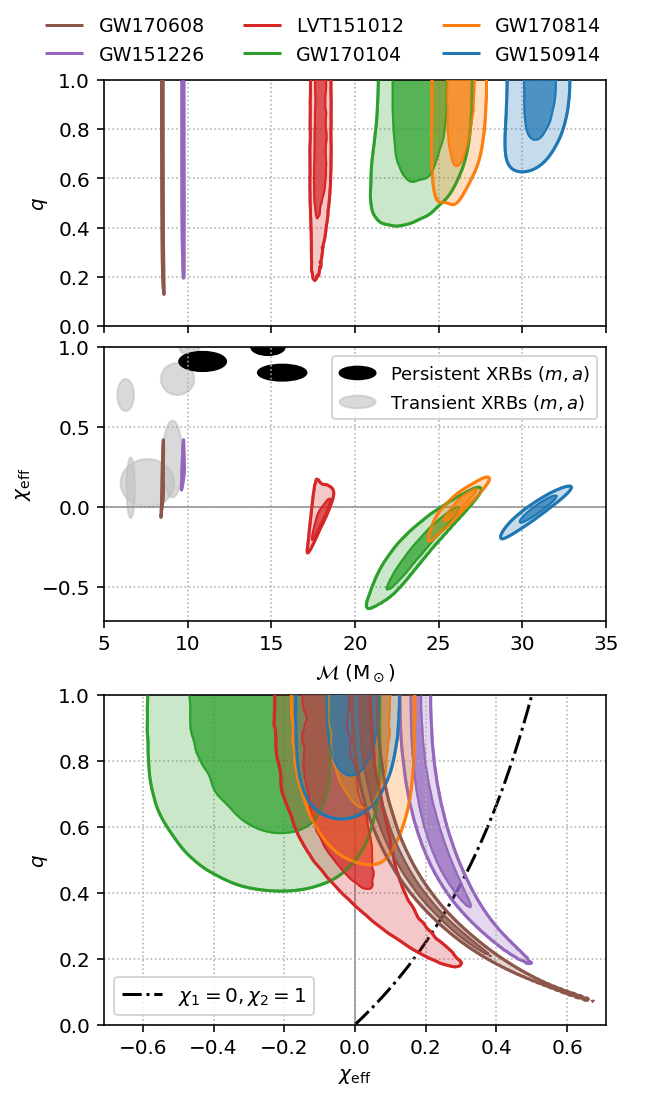

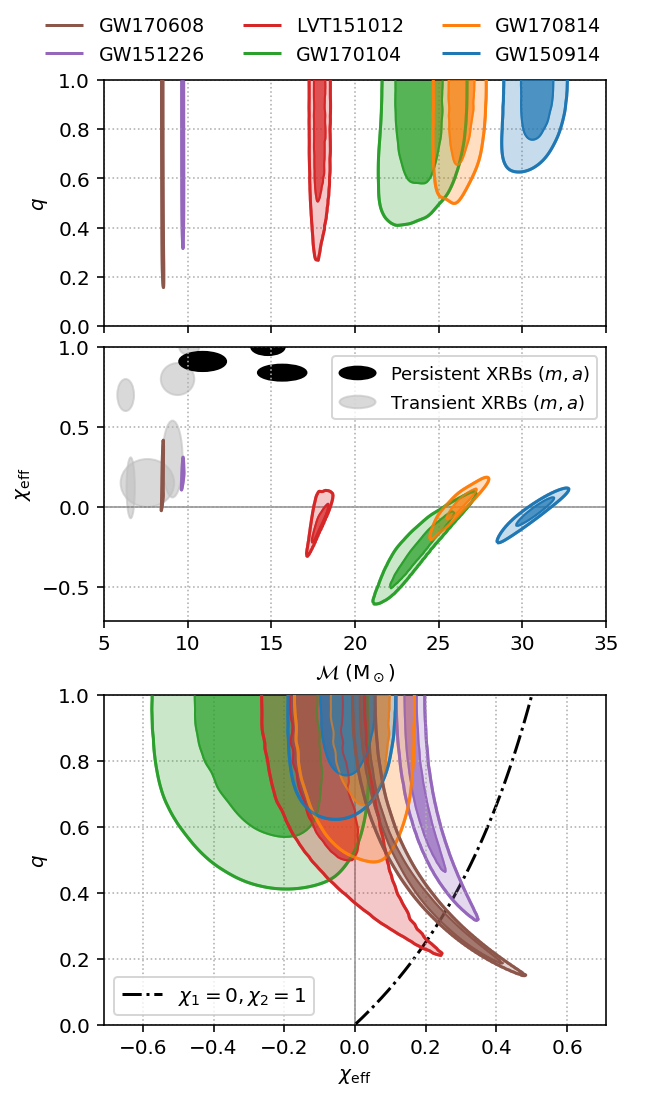

In [24]:
color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']
index_list = [5,4,3,2,1,0]
colors = {event: color_list[index_list[i]] for i, event in enumerate(events)}
zorder={'GW150914': 5, 
        'GW151226': 1, 
        'LVT151012': 3, 
        'GW170104': 2, 
        'GW170608': 6,
        'GW170814': 4}

n_rows = len(grid_2d_params)

plt.clf()
for prior in priors:
    print(prior.text)
    for CA in coherences_approximants:
        #fig, ax = plt.subplots(n_rows, 1, figsize=(4.7, 3.3*n_rows))

        assert grid_params == ['M_chirp', 'q', 'chi_eff']  # Or change the following by the commented above
        fig = plt.figure(figsize=(4.5, 2.7*n_rows));
        gs_top = gridspec.GridSpec(n_rows, 1, height_ratios=[.9,1, 1.4], hspace=.07, top=.935)
        gs_bottom = gridspec.GridSpec(n_rows, 1, height_ratios=[.9,1, 1.4])
        ax1 = fig.add_subplot(gs_top[0, 0])
        ax2 = fig.add_subplot(gs_top[1, 0], sharex=ax1)
        ax3 = fig.add_subplot(gs_bottom[2, 0])
        #ax = np.array([plt.subplot(gs[i]) for i in range(len(grid_params))])
        ax = np.array([ax1, ax2, ax3])


        for row, xy_pars in enumerate(grid_2d_params):
            x_par, y_par = xy_pars if xy_pars != ('q', 'chi_eff') else ('chi_eff', 'q')
            plt.sca(ax[row])
            for event in events:
                plt.contourf(grid_2d[event][xy_pars][x_par], 
                             grid_2d[event][xy_pars][y_par], 
                             grid_2d[event][xy_pars]['posterior', prior.name, (*CA)],
                             levels=levels[event][prior.name, (*CA), xy_pars],
                             colors=[colors[event]],
                             alpha=.25,
                             zorder=zorder[event]
                            )
                plt.contourf(grid_2d[event][xy_pars][x_par], 
                             grid_2d[event][xy_pars][y_par], 
                             grid_2d[event][xy_pars]['posterior', prior.name, (*CA)],
                             levels=[levels[event][prior.name, (*CA), xy_pars][1], np.inf],
                             colors=[colors[event]],
                             alpha=.8,
                             zorder=zorder[event]
                            )
                contours = plt.contour(grid_2d[event][xy_pars][x_par], 
                                       grid_2d[event][xy_pars][y_par], 
                                       grid_2d[event][xy_pars]['posterior', prior.name, (*CA)],
                                       levels=levels[event][prior.name, (*CA), xy_pars],
                                       colors=[colors[event]],
                                       linewidths=[1.5, 1],
                                       zorder=zorder[event],
                                       )
                contours.collections[0].set_label(event)
                plt.contour(grid_2d[event][xy_pars][x_par], 
                            grid_2d[event][xy_pars][y_par], 
                            grid_2d[event][xy_pars]['posterior', prior.name, (*CA)],
                            levels=levels[event][prior.name, (*CA), xy_pars],
                            colors=[colors[event]],
                            linewidths=[1.5, 1],
                            zorder=10+zorder[event],
                            alpha=.6,
                           )
            if [x_par, y_par] == ['q', 'chi_eff']:
                x_par, y_par = y_par, x_par
            if x_par == 'q':
                plt.xlim(0, 1)
            if y_par == 'q':
                plt.ylim(0, 1)
            if x_par == 'chi_eff':
                plt.axvline(0, c='grey', lw=.75, zorder=-1)
                plt.xlim(-.71, .71)
            if y_par == 'chi_eff':
                plt.axhline(0, c='grey', lw=.75, zorder=-1)
                plt.ylim(-.71, .71)
            if x_par == 'M_chirp' and y_par == 'chi_eff':
                # pe, te = persistent ellipse, transient ellipse
                for i, p in persistents.iterrows():
                    pe = Ellipse(xy=(p.M, p.a), width=2*p.M_err, height=2*p.a_err)
                    plt.gca().add_patch(pe)
                    pe.set_edgecolor('k')
                    pe.set_facecolor('k')
                for i, t in transients.iterrows():
                    te = Ellipse(xy=(t.M, t.a), width=2*t.M_err, height=2*t.a_err, zorder=-10)
                    plt.gca().add_patch(te)
                    te.set_edgecolor('silver')
                    te.set_facecolor('silver')
                    te.set_alpha(.6)
                    
                plt.legend([pe, te], ['Persistent XRBs $(m,a)$', 'Transient XRBs $(m,a)$'],
                           handler_map={mpatches.Ellipse: HandlerEllipse()}, loc='upper right', fontsize=9)
                plt.xlim(5, 35)
                plt.ylim(ymax=1)
            plt.grid(ls=':')
            if set([x_par, y_par]) == set(['q', 'chi_eff']):
                qs = np.linspace(0, 1)
                l = plt.plot(chi_eff_locked(qs), qs,  'k-.', zorder=-1)
                plt.legend(l, (r'$\chi_1 = 0, \chi_2 = 1$',), loc='lower left')

            if row != 0:
                plt.xlabel(latex[x_par] + unit[x_par])
            plt.ylabel(latex[y_par] + unit[y_par])
        handles, labels = ax[0].get_legend_handles_labels()
        fig.legend(handles, labels, 
                   loc='upper center', ncol=3, fontsize=9.5, frameon=False)
        ax[0].tick_params(labelbottom='off')
        #plt.tight_layout(h_pad=-0.04)
        plt.savefig('figures/{}_{}.pdf'.format(prior.name, '_'.join(CA)), bbox_inches='tight')
        plt.show()

Lines of constant $\chi_{PN}$

In [25]:
def eta_of_q(q):
    return q / (1+q)**2
def chiPN_of_q_chieff(q, chi_eff):
    return chi_eff * (1 - 76/113 * eta_of_q(q))
def chieff_of_q_chiPN(q, chi_PN):
    return chi_PN / (1-76/113 * eta_of_q(q))

In [26]:
def f(par):
    if par == 'M_chirp':
        return 10 * np.ones_like(grid_2d[event]['q', 'chi_eff']['q'])
    else:
        return grid_2d[event]['q', 'chi_eff'][par]

In [27]:
# Interpolate sensitive volume over each event's grid
min_val, max_val = ({par: f(full_p_grid[par]) for par in grid_params} for f in (min, max))
for PA in PSDs_approximants:
    V = full_p_grid['SNR_1Mpc_' + '_'.join(PA)].values.reshape(full_p_grid_metadata.values[0])**3
    for event in events:
        grid_2d[event]['q', 'chi_eff']['V', (*PA)] = ndimage.map_coordinates(
            V, [(f(par) - min_val[par]) * (
                (full_p_grid_metadata[par][0]-1) / (max_val[par]-min_val[par])) for par in grid_params])


LIGO


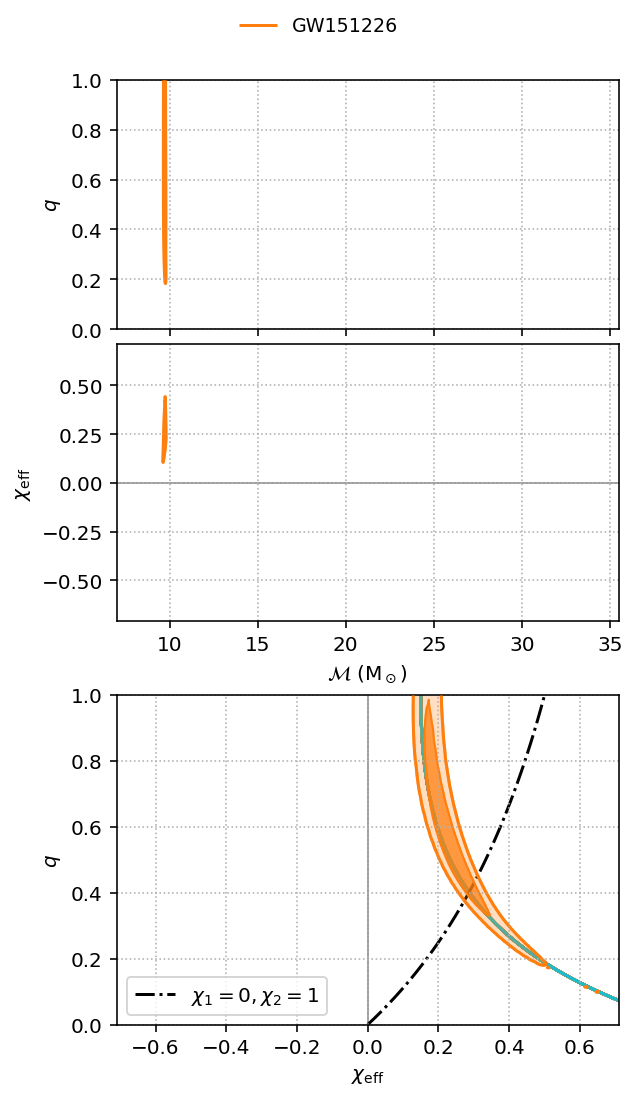

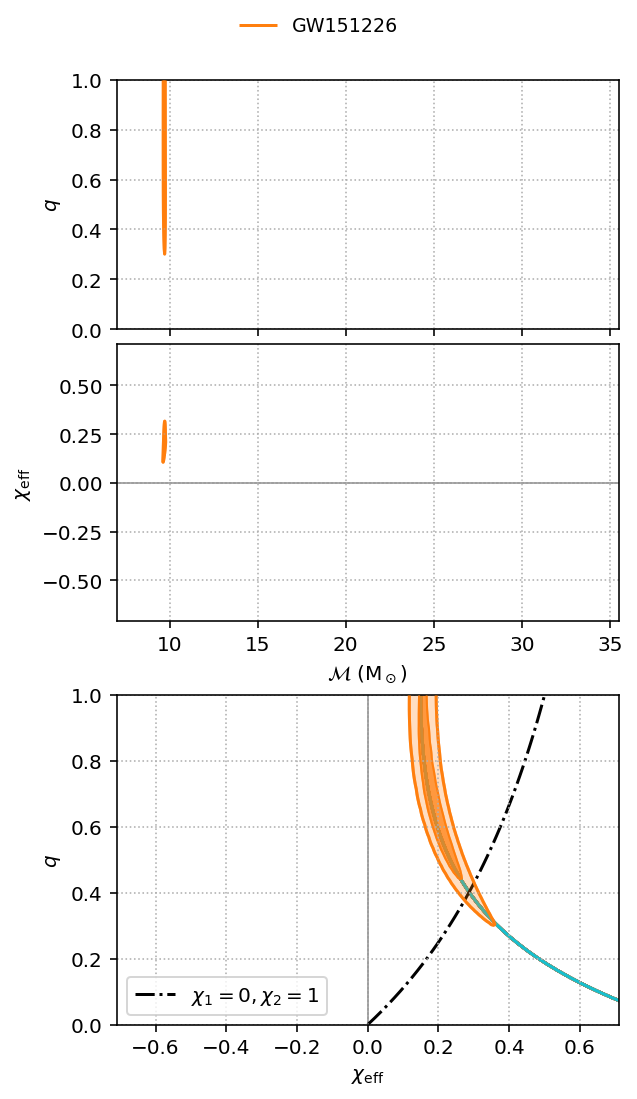

Uniform in Mchirp, q, Xeff


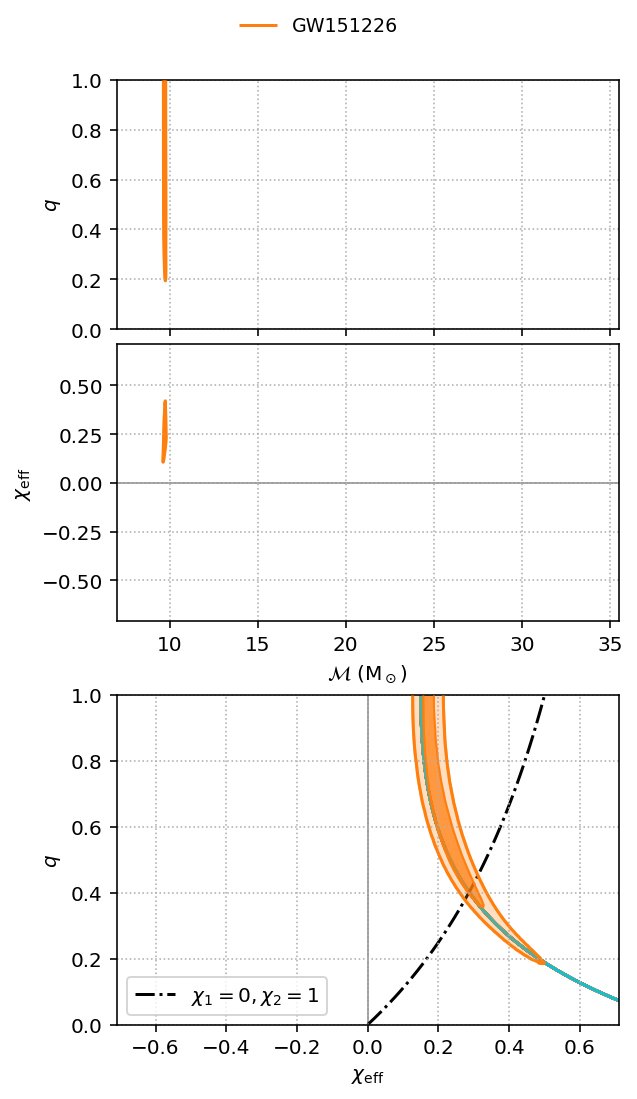

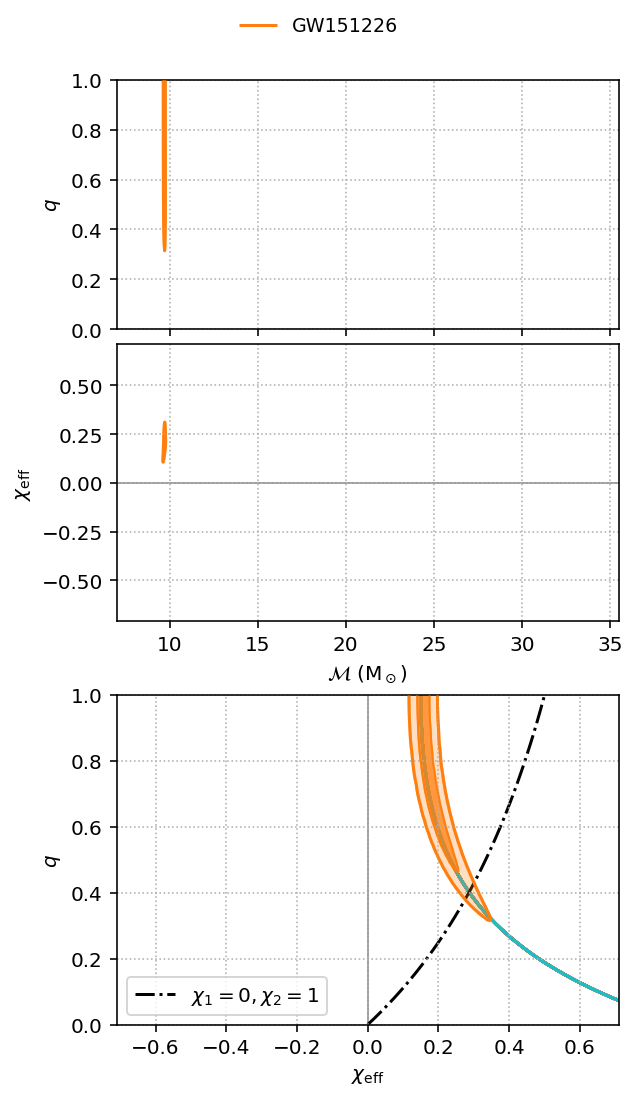

In [28]:
color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']
index_list = [0,1,2,3,5,4]  # Swap last two so it is colorblind-friendly
colors = {event: color_list[index_list[i]] for i, event in enumerate(events)}
zorder={'GW150914': 5, 
        'GW151226': 1, 
        'LVT151012': 3, 
        'GW170104': 2, 
        'GW170608': 6,
        'GW170814': 4}

n_rows = len(grid_2d_params)

chi_PNs = np.linspace(-1, 1, 20)
qs = np.linspace(0,1)

plt.clf()
for prior in priors:
    print(prior.text)
    for CA in coherences_approximants:
        #fig, ax = plt.subplots(n_rows, 1, figsize=(4.7, 3.3*n_rows))

        assert grid_params == ['M_chirp', 'q', 'chi_eff']  # Or change the following by the commented above
        fig = plt.figure(figsize=(4.5, 2.7*n_rows));
        gs_top = gridspec.GridSpec(n_rows, 1, height_ratios=[.9,1, 1.4], hspace=.05, top=.935)
        gs_bottom = gridspec.GridSpec(n_rows, 1, height_ratios=[.9,1, 1.4])
        ax1 = fig.add_subplot(gs_top[0, 0])
        ax2 = fig.add_subplot(gs_top[1, 0])
        ax3 = fig.add_subplot(gs_bottom[2, 0])
        #ax = np.array([plt.subplot(gs[i]) for i in range(len(grid_params))])
        ax = np.array([ax1, ax2, ax3])


        for row, xy_pars in enumerate(grid_2d_params):
            x_par, y_par = xy_pars if xy_pars != ('q', 'chi_eff') else ('chi_eff', 'q')
            plt.sca(ax[row])
            for event in ['GW151226']:#events:
                plt.contourf(grid_2d[event][xy_pars][x_par], 
                             grid_2d[event][xy_pars][y_par], 
                             grid_2d[event][xy_pars]['posterior', prior.name, (*CA)],
                             levels=levels[event][prior.name, (*CA), xy_pars],
                             colors=[colors[event]],
                             alpha=.25,
                             zorder=zorder[event]
                            )
                plt.contourf(grid_2d[event][xy_pars][x_par], 
                             grid_2d[event][xy_pars][y_par], 
                             grid_2d[event][xy_pars]['posterior', prior.name, (*CA)],
                             levels=[levels[event][prior.name, (*CA), xy_pars][1], np.inf],
                             colors=[colors[event]],
                             alpha=.8,
                             zorder=zorder[event]
                            )
                contours = plt.contour(grid_2d[event][xy_pars][x_par], 
                                       grid_2d[event][xy_pars][y_par], 
                                       grid_2d[event][xy_pars]['posterior', prior.name, (*CA)],
                                       levels=levels[event][prior.name, (*CA), xy_pars],
                                       colors=[colors[event]],
                                       linewidths=[1.5, 1],
                                       zorder=zorder[event],
                                       )
                contours.collections[0].set_label(event)
                plt.contour(grid_2d[event][xy_pars][x_par], 
                            grid_2d[event][xy_pars][y_par], 
                            grid_2d[event][xy_pars]['posterior', prior.name, (*CA)],
                            levels=levels[event][prior.name, (*CA), xy_pars],
                            colors=[colors[event]],
                            linewidths=[1.5, 1],
                            zorder=10+zorder[event],
                            alpha=.5,
                           )
            if [x_par, y_par] == ['chi_eff', 'q']:
                for chi_PN in chi_PNs:
                    #plt.plot(chieff_of_q_chiPN(qs, chi_PN), qs, 'lightgrey', zorder=-10)
                    plt.plot(0.15-3*(eta_of_q(qs)-.25), qs, zorder=-10)
            if x_par == 'q':
                plt.xlim(0, 1)
            if y_par == 'q':
                plt.ylim(0, 1)
            if x_par == 'chi_eff':
                plt.axvline(0, c='grey', lw=.75, zorder=-1)
                plt.xlim(-.71, .71)
            if y_par == 'chi_eff':
                plt.axhline(0, c='grey', lw=.75, zorder=-1)
                plt.ylim(-.71, .71)
            if x_par == 'M_chirp':
                plt.xlim(7, 35.5)
            plt.grid(ls=':')
            if set([x_par, y_par]) == set(['q', 'chi_eff']):
                qs = np.linspace(0, 1)
                l = plt.plot(chi_eff_locked(qs), qs,  'k-.', zorder=-1)
                plt.legend(l, (r'$\chi_1 = 0, \chi_2 = 1$',), loc='lower left')
            if row != 0:
                plt.xlabel(latex[x_par] + unit[x_par])
            plt.ylabel(latex[y_par] + unit[y_par])
        handles, labels = ax[0].get_legend_handles_labels()
        fig.legend(handles, labels, 
                   loc='upper center', ncol=3, fontsize=9.5, frameon=False)
        ax[0].tick_params(labelbottom='off')
        #plt.tight_layout(h_pad=-0.04)
        plt.savefig('figures/{}_{}.pdf'.format(prior.name, '_'.join(CA)), bbox_inches='tight')
        plt.show()

#### Changing the prior

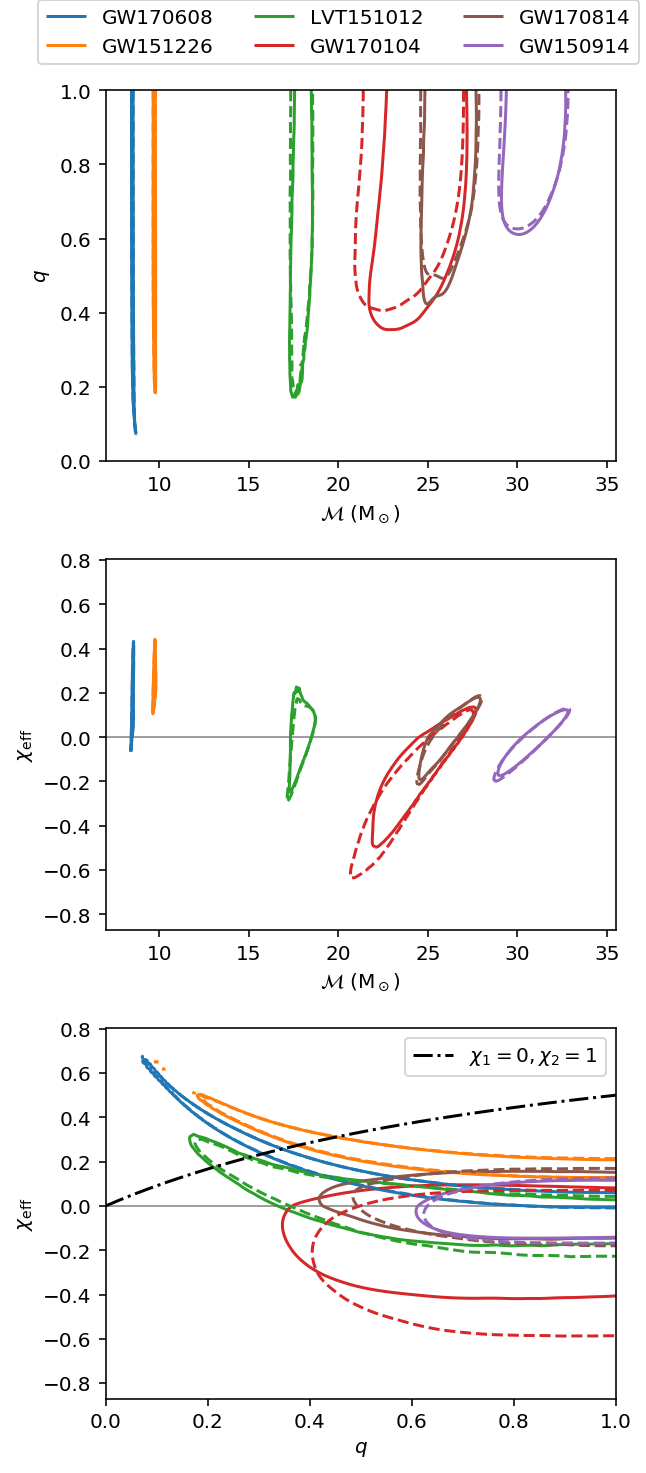

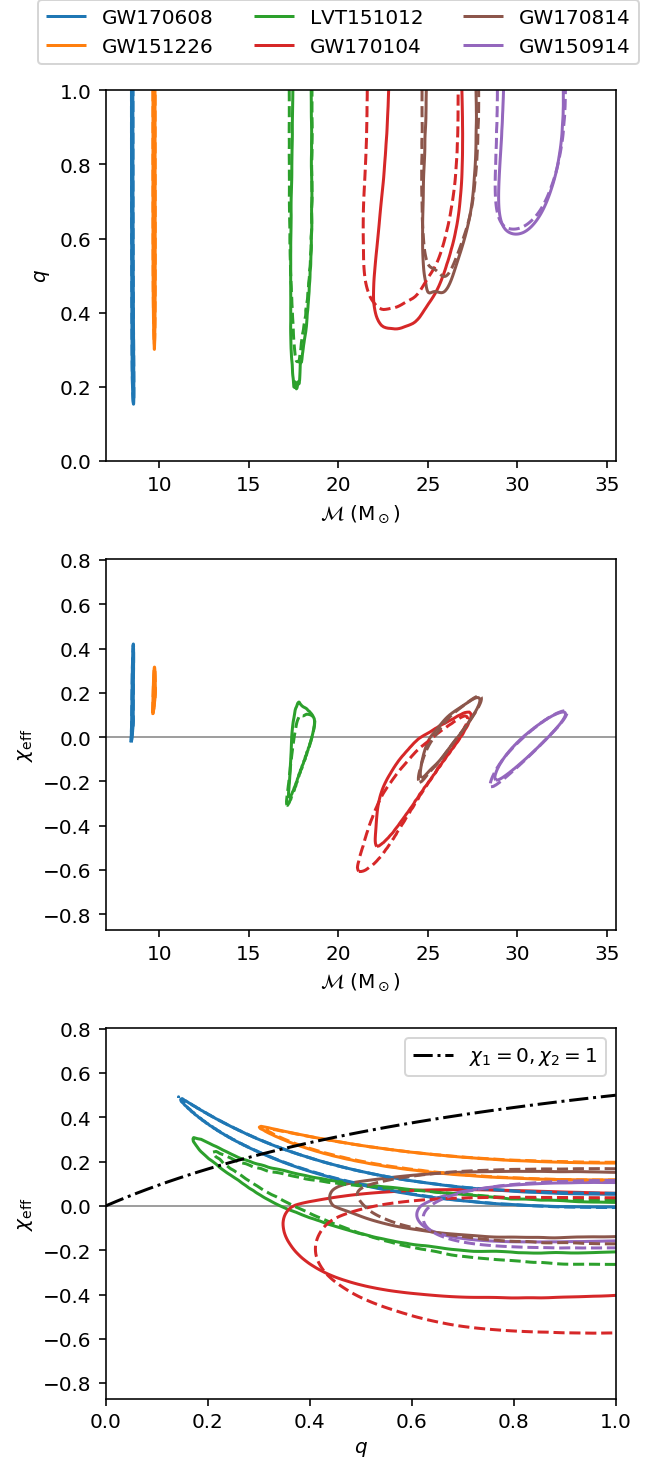

In [29]:
color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']
index_list = [0,1,2,3,5,4]  # Swap last two so it is colorblind-friendly
colors = {event: color_list[index_list[i]] for i, event in enumerate(events)}

ls_list = ['-', '--', ':', '-.']
ls = {prior.name: ls_list[i % len(ls_list)] for i, prior in enumerate(priors)}

n_rows = len(grid_2d_params)

plt.clf()
for CA in coherences_approximants:
    fig, ax = plt.subplots(n_rows, 1, figsize=(4.7, 3.3*n_rows))
    for row, (x_par, y_par) in enumerate(grid_2d_params):
        plt.sca(ax[row])
        for prior in priors:
            for event in events:
                xy_posterior = grid_2d[event][x_par, y_par]['posterior', prior.name, (*CA)].T
                contours = plt.contour(grid_1d[event][x_par], grid_1d[event][y_par], xy_posterior,
                                       levels=levels[event][prior.name, (*CA), (x_par, y_par)][:1],
                                       colors=colors[event], linestyles=ls[prior.name])
                if prior == priors[0]:
                    contours.collections[0].set_label(event)
        
        if x_par == 'q':
            plt.xlim(0, 1)
        if y_par == 'q':
            plt.ylim(0, 1)
        if x_par == 'chi_eff':
            plt.axvline(0, c='grey', lw=.75, zorder=-1)
        if y_par == 'chi_eff':
            plt.axhline(0, c='grey', lw=.75, zorder=-1)
        if x_par == 'M_chirp':
            plt.xlim(7, 35.5)
            
        if set([x_par, y_par]) == set(['q', 'chi_eff']):
            qs = np.linspace(0, 1)
            l = plt.plot(qs, chi_eff_locked(qs), 'k-.')
            plt.legend(l, (r'$\chi_1 = 0, \chi_2 = 1$',), loc='upper right')
        plt.xlabel(latex[x_par] + unit[x_par])
        plt.ylabel(latex[y_par] + unit[y_par])
    handles, labels = ax[0].get_legend_handles_labels()
    fig.legend(handles, labels, 
               loc='upper center', ncol=3, bbox_to_anchor=(.5, 1.04))
    plt.tight_layout()
    #plt.savefig('figures/change_prior_{}.pdf'.format(approximant), bbox_inches='tight', dpi=300)
    plt.show()

#### Just $\mathcal M, \chi_{\rm eff}$

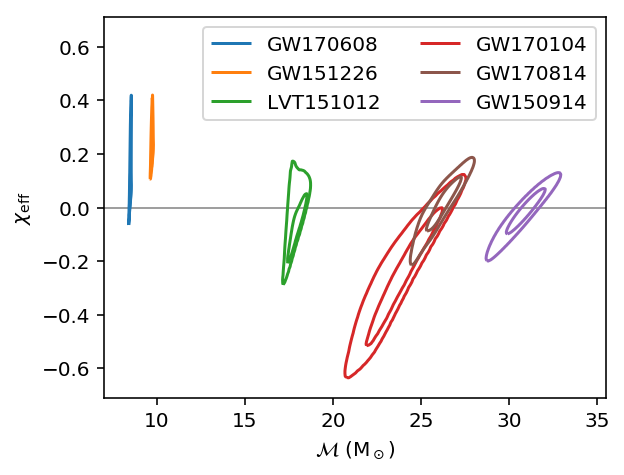

In [30]:

color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']
index_list = [0,1,2,3,5,4]  # Swap last two so it is colorblind-friendly
colors = {event: color_list[index_list[i]] for i, event in enumerate(events)}

CA = ['coherent', 'SEOBNRv4_ROM']
prior = uniform_in_Mchirp_q_chieff
x_par = 'M_chirp'
y_par = 'chi_eff'

plt.clf()
plt.figure(figsize=(4.5,3.5))
for event in events:
    xy_posterior = grid_2d[event][x_par, y_par]['posterior', prior.name, (*CA)].T
    contours = plt.contour(grid_1d[event][x_par], grid_1d[event][y_par], xy_posterior,
                           levels=levels[event][prior.name, (*CA), (x_par, y_par)],
                           colors=colors[event])
    contours.collections[0].set_label(event)

if y_par == 'chi_eff':
    plt.axhline(0, c='grey', lw=.75, zorder=-1)
    plt.ylim(-.71, .71)
if x_par == 'M_chirp':
    plt.xlim(7, 35.5)

plt.xlabel(latex[x_par] + unit[x_par])
plt.ylabel(latex[y_par] + unit[y_par])
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(ncol=2)
plt.savefig('figures/{}_Mchirp_chieff_{}.pdf'.format(prior.name, '_'.join(CA)), bbox_inches='tight')
plt.show()

#### Just $q, \chi_{\rm eff}$

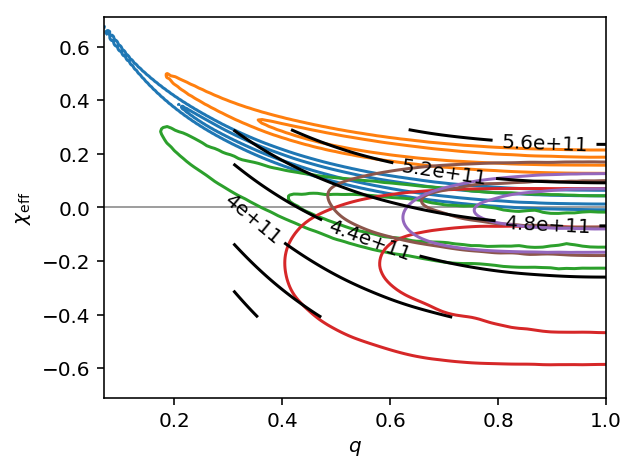

In [31]:

color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']
index_list = [0,1,2,3,5,4]  # Swap last two so it is colorblind-friendly
colors = {event: color_list[index_list[i]] for i, event in enumerate(events)}

CA = ['coherent', 'SEOBNRv4_ROM']
prior = uniform_in_Mchirp_q_chieff
x_par = 'q'
y_par = 'chi_eff'

plt.clf()
plt.figure(figsize=(4.5,3.5))
for event in events:
    xy_posterior = grid_2d[event][x_par, y_par]['posterior', prior.name, (*CA)].T
    contours = plt.contour(grid_1d[event][x_par], grid_1d[event][y_par], xy_posterior,
                           levels=levels[event][prior.name, (*CA), (x_par, y_par)],
                           colors=colors[event])
    contours.collections[0].set_label(event)

if y_par == 'chi_eff':
    plt.axhline(0, c='grey', lw=.75, zorder=-1)
    plt.ylim(-.71, .71)
if x_par == 'M_chirp':
    plt.xlim(7, 35.5)
Vc=plt.contour(grid_2d[event][x_par, y_par][x_par], 
            grid_2d[event][x_par, y_par][y_par], 
            grid_2d[event][x_par, y_par]['V', (*PA)],
           colors='k')
plt.clabel(Vc, fmt='%.2g')

plt.xlabel(latex[x_par] + unit[x_par])
plt.ylabel(latex[y_par] + unit[y_par])
handles, labels = plt.gca().get_legend_handles_labels()
#plt.legend(ncol=2)
plt.savefig('figures/{}_constant_V_{}.pdf'.format(prior.name, '_'.join(CA)), bbox_inches='tight')
plt.show()